Anomaly Detection with Iterative Quantile Estimation and T-digest
=================================================================

Project group 11

Alexander Karlsson, Alvin Jin and George Osipov

13 January 2021

1. Introduction
---------------

Anomaly detection is often implemented as a threshold detector where
scalar valued scores (often computed from a higher dimensional sample)
above a set threshold are classified as detections. It is often desired
that the number of false alarms, i.e. non-anomalous samples that have
higher score than the threshold, should be constant. This requires an
adaptive threshold if the distribution of the scores varies with time.
In this project we will look at two aspects of anomaly detection 1. How
to calulate the threshold or quantile for a fixed distribution 2. How to
apply this quantile to distributions that change over time using a
simple filter

For quantile estimation (QE) we will use t-digest and compare it to a
more naive approach which will be presented later. A problem for both
these methods are data streams that arise from distributions that change
over time. Assume that each sample received a time $t$ can be written as

$$ x(t) = f(t) + w(t), $$

where $f(t)$ is a trend value that varies with time and $w(t)$ is a
random variable with a distribution that may also vary with time. We are
interested in finding anomalies in $w(t)$. If we were to estimate a
quantile from samples obtained from a time interval $T*s$, the anomalies
would depend on both $f(t)$ and $w(t)$, e.g. if $f(t)$ is a linearly
increasing function and $w(t)$ is constant, most of the anomalous
samples would be the more recent ones. This could be mitigated by taking
samples from a small enough interval such that $f(t)$ and $w(t)$ can be
considered constant during that time. This approach requires a
continuous update of the estimated quantile, which we denote $q\[n\]$,
where $n$ is the index of the time interval at time $nT*s$. In some
cases this may be a sufficently accurate solution. However, assume now
that $w(t)$ is constant but will occasionally change to a distribution
with higher mean, i.e. this change is now the anomaly we are trying to
detect. If we use the same target quantile in all time steps, these
anomalies would go undetected. A compromise is to filter the stream of
estimated quantiles $q\[1\],q\[2\],...,q\[n\]$ in a manner that
preserves scalability. The data stream we will look at will have the
following form. Each time step yields $N$ samples with Gaussian
distribution with standard deviation $\\sigma$=1 and mean $$
\\mu\[n\]=\\frac{n}{1000}, $$ and with 5$\\%$ probability, 1$\\%$ of the
data will have mean $$ \\mu\[n\]=\\frac{n}{1000} + 2. $$

2. QE with t-digest
-------------------

With t-digest the distribution is estimated using a set of clusters
where each cluster is represented by a mean value and weight (the number
of samples assigned to the cluster). Clusters at the tail ends of the
distribution will have smaller weights. This is determined by a
non-decreasing function referred to as a scale function and will result
in an error in the QE that is relative to the quantile rather than an
absolute error, which is the fundamental idea with t-digest. Any
quantile can be estimated by interpolating between cluster points. The
algorithm is explained in detail in \[Dunning\]. The clusters can be
computed in a scalable manner which makes the algorithm suitable for
large datasets.

3. Naive QE
-----------

A simpler and perhaps more naive approach for empirical QE is to
estimate the desired quantile as the the $k$'th ordered statistic, i.e.
the value $q=x\_k$ for which $k$ samples are smaller or equal to $q$,
e.g. the 95'th percentile from 1000 samples would then be estimated as
the 950'th ordered statistic. If the data is i.i.d. the estimated
quantile will then be a random variable with pdf \[Rohling\]

$$ p(x\_k)= k {N\\choose k} \\left\[ P(x) \\right\]^{k-1} \\left\[
1-P(x) \\right\]^{N-k} p(x), $$

where $x\_k$ is the $k$'th ordered statistic, $P(x)$ is the cdf of the
random variable $x$ and $p(x)$ is the pdf.

However, if the data is distributed, sorting becomes problematic. We
therefore present an iterative, and more scalable, method of finding the
desired quantile (or rather, the ordered statistic). We start with a
random guess $\\hat{q}$ (e.g. the mean) and count the number of samples
that are larger than $\\hat{q}$. This can be done in a distributed
fashion where each node reports on the number of samples greater than
$\\hat{q}$ as well as the total number of samples in each node. These
number are then aggregated at the master node and the ratio yields an
estimate of a quantile for $\\hat{q}$. If this is larger than the
desired quantile, $\\hat{q}$ should be decreased and vice versa. One
then proceeds by iteratively changing $\\hat{q}$ until the desired
quantile is found. The search can be made efficient using the following
steps

1.  Choose an integer $k$ that correspends to the desired quantile, e.g.
    $k$=950 for $N$=1000 (95'th percentile).

2.  Arbitrarily choose an initial guess of $\\hat{q}$.

3.  Count the number of samples that are greater than $\\hat{q}$, call
    this $M$. If $M &gt; N-k$ increase $\\hat{q}$ by 1, then by 2,4,8,16
    etc. until $M &lt; N-k$ (or reverse this process if $M$ is initially
    lower than $N-k$ ). We now have an upper limit (U) and a lower
    limit (L) for the desired quantile, $\\hat{q}*U$ and $\\hat{q}*L$.
    Let $d$ = $\\hat{q}*U$ - $\\hat{q}*L$.

4.  Let $\\hat{q} = \\hat{q}\_L$. In each iteration update $\\hat{q}
    \\leftarrow \\hat{q} + ud/2$ and then $d \\leftarrow d/2$ where $u$
    is +1 if $M &gt; N-k$ and -1 otherwise. Stop iterating when $M=N-k$.

This approach will converge to a solution in time proportional to
log$\_2(N)$. For other types of iterative searches for finding an
emperical quantile see \[Möller\].

4. Filtering Time Varying Quantiles
-----------------------------------

An interesting problem with both the presented method for QE and
t-digest is how to balance new and old estimates. One approach is to
make one new estimate for each new batch. This will fail however if one
batch suddenly contains a larger burst of "outliers" as these might then
go undetected due to the temporary change of the statistics.

Another is to estimate the desired quantiles from one batch and then
keep this estimate in the proceeding batches. This will also fail if the
distribution varies slowly, i.e. with time the calculated parameters
will correspond to different quantiles than what was originally desired.
One could mitigate this effect by averaging or updating new estimates
with older. However if we estimate the quantiles based on all samples
from the beginning up until time $n$ we need to weight them properly,
otherwise we may still have large errors due to distributions that
change with time.

A simple tradeoff is to introduce a filter with some forget rate $T$,
i.e. samples that are older than $T$ no longer effect the current
estimate while the more recent estimates are weighted together. A basic
approach is an equally weighted sliding window of size $T$ where

$$ \\bar{q}\[n\]= \\frac{1}{T}\\sum\_{i=0}^{T-1}q\[n-i\] $$

is the weighted estimate and $q\[n\]$ is the quantile estimated from
batch/time $n$. This requires storing $T$ samples in a memory and
writing (i.e. replacing the oldest sample with the newest) in each time
step, which may or may not be an issue. Another is to have a filter with
exponential decay where each sample $q\[i\]$ for $i=0,...,n$ is weighted
by a factor $ce^{-(n-i)/\\tau}$ for $\\tau&gt;0$ and

$$ c= \\left\[\\sum\_{i=0}^{\\infty}e^{-i/\\tau}\\right\]^{-1} = 1 -
e^{-1/\\tau}. $$

The weights of previous samples at time $n=100$ for two different values
of $\\tau$ are shown below

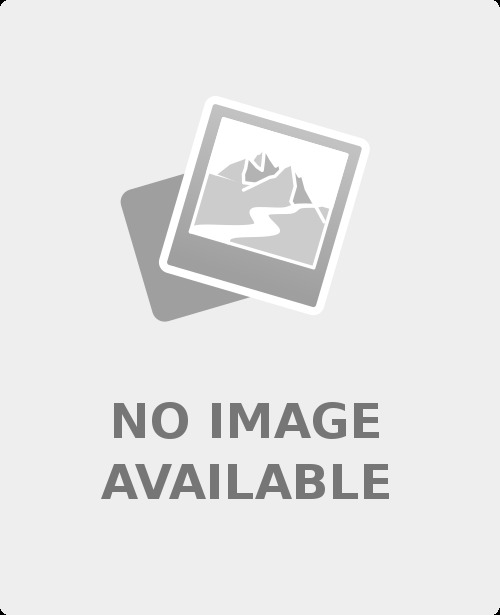

This can be simply implemented with the filter

$$ \\bar{q}\[n\]= \\bar{q}\[n-1\]e^{-1/\\tau} + cq\[n\] =
\\sum\_{i=0}^{n}cq\[i\]e^{(i-n)/\\tau}. $$

The sum of $n$ weights is

$$ \\sum\_{i=0}^{n} ce^{-i/\\tau} = c\\frac{1 -
e^{-n/\\tau}}{1-e^{-1/\\tau}} = 1 - e^{-n/\\tau} $$

which can be approximated as one, e.g. if $n=5\\tau$ the weights mass is
greater than 0.99. If we regard $q\[n\]$ as a random variable with
expected value $\\mu$ and variance $\\sigma^2$ that have been
approximately constant for a duration of $L\\gg\\tau$ samples the filter
will be asymptotically unbiased

$$ \\mathbf{E}\\left\[q\[n\] \\right\] =
\\mathbf{E}\\left\[\\sum*{i=0}^{n}cq\[i\]e^{(i-n)/\\tau} \\right\] =
\\mathbf{E}\\left\[q\[i\] \\right\] \\sum*{i=0}^{n}ce^{-i/\\tau} =
\\mu(1 - e^{-n/\\tau})\\approx \\mu. $$

Assuming for the sake of analysis that $\\mu=0$ and that $q\[n\]$ is
uncorrelated, i.e. $\\mathbf{E}\\left\[q\[j\]q\[i\] \\right\]=
\\sigma^2$ if $j=i$ and $\\mathbf{E}\\left\[q\[j\]q\[i\] \\right\]= 0$
otherwise, we get the variance as

$$ \\text{var}\\left\[q\[n\] \\right\] =
\\mathbf{E}\\left\[\\left(\\sum*{i=0}^{n}cq\[i\]e^{(i-n)/\\tau}
\\right)^2\\right\] = \\mathbf{E}\\left\[q\[i\]^2 \\right\]
\\sum*{i=0}^{n}c^2e^{-2i/\\tau} = \\sigma^2c^2\\frac{(1 -
e^{-2n/\\tau})}{(1 - e^{-2/\\tau})} = \\sigma^2\\frac{(1 -
e^{-1/\\tau})^2(1 - e^{-2n/\\tau})}{(1 - e^{-1/\\tau})(1 +
e^{-1/\\tau})} \\approx \\sigma^2\\frac{(1 - e^{-1/\\tau})}{(1 +
e^{-1/\\tau})} = \\gamma\\sigma^2$$

i.e. a reduction by a factor $\\gamma$. This can be compared to the
factor $1/T$ which is the reduction in variance from a rectangular
sliding window of length $T$, e.g. if $T=100$ we get the same steady
state reduction in variance if $\\tau=50$. The value of $\\gamma$ as a
function of $\\tau$ is shown below

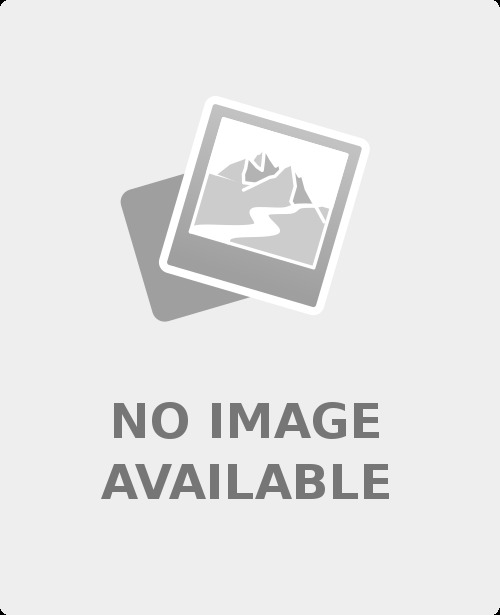

The transfer function for this filter in $z$-domain is $$ H(z) =
\\frac{\\bar{Q}(z)}{Q(z)} = \\frac{1-e^{-1/\\tau}}{1 -
e^{-1/\\tau}z^{-1}}. $$ The frequency response, obtained by letting
$z=e^{j2\\pi\\nu}$ where the normalized frequency is $\\nu = T*sf$, $f$
is the frequency and $T*s$ is the time between samples, is shown below

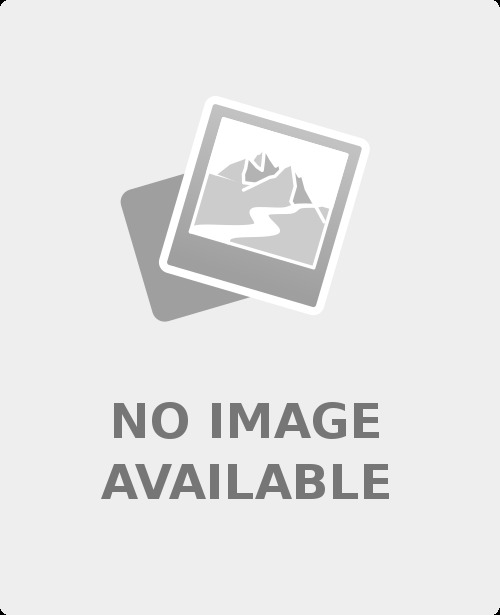

The figure shows the tradeoff between supressing (in magnitude) higher
frequencies and following changes (i.e. keeping phase). The trend that
the filter should follow should be slow enough such that it can be
approximated as constant for a duration of $L\\gg\\tau$, i.e. depending
of the frequency of the desired trend, the sampling rate, $1/T\_s$,
needs to be high enough to satisfy this. If the flow of samples is
constant this will in turn limit the number of samples in each batch and
the smallest quantile that can be estimated.

5. Implementation
-----------------

In [ ]:
// neccessary imports
import org.isarnproject.sketches.java.TDigest
import org.isarnproject.sketches.spark.tdigest._
import scala.util.Random
import scala.util.Random._
import org.apache.spark.sql.functions._
import org.apache.spark.sql.Dataset
import scala.math._
import org.apache.commons.math3.distribution.NormalDistribution

  

>     import org.isarnproject.sketches.java.TDigest
>     import org.isarnproject.sketches.spark.tdigest._
>     import scala.util.Random
>     import scala.util.Random._
>     import org.apache.spark.sql.functions._
>     import org.apache.spark.sql.Dataset
>     import scala.math._
>     import org.apache.commons.math3.distribution.NormalDistribution

In [ ]:
// Define 2-Gaussian mixture model
// This code is taken from [041_SketchingWithTDigest]

def myMixtureOf2Normals( normalLocation: Double, abnormalLocation: Double, normalWeight: Double, r: Random) : Double = {
  val sample = if (r.nextDouble <= normalWeight) {r.nextGaussian+normalLocation } 
               else {r.nextGaussian + abnormalLocation} 
  return sample
   }

  

>     myMixtureOf2Normals: (normalLocation: Double, abnormalLocation: Double, normalWeight: Double, r: scala.util.Random)Double

In [ ]:
// Define the naive QE function
def itrQuantEstimator[D](data:Dataset[D], target: Int): Double = {
  // find an interval
  var x = 0.0
  var x_old = 0.0
  var qfound=false
  var step = 1.0
  var Na_old = data.filter($"value">x).count() 
  var Na = Na_old
  var scale=1.0
  if (Na_old < 10){scale= (-1)}
  step = step*scale  
  var Nitr = 0
  while (qfound == false){
    // updata iteretion count
    Nitr = Nitr + 1
    // update x
    x = x + step
    // update step
    step = step*2
    Na = data.filter($"value">x).count()
    if (Na*scale < target*scale){
      qfound = true}
    else{
      Na_old=Na
      x_old=x
    }
  }

  // set upper and lower limit
  var UL = x_old
  var LL=x
  if (x_old < x){UL = x; LL=x_old }

  // Find the quantile for current batch
  var Int = UL - LL
  qfound = false
  x=LL
  scale=1
  while (qfound == false){
    // updata iteretion count
    Nitr = Nitr + 1
    // update x
    Int = Int/2
    x = x + scale*Int
    Na = data.filter($"value">x).count()
    if (Na == target){
      qfound = true}
    else if (Na < target){
           // decrease x
      scale= -1
    }
    else if(Na > target){
    // increase x
      scale= 1
    }
  
  }
  return x
}

  

>     itrQuantEstimator: [D](data: org.apache.spark.sql.Dataset[D], target: Int)Double

In [ ]:
// Estimate quantiles in loop 

val N = 100000 // samples per batch

// Naive QE parameters
val Nmk = 10 // integer "N - k"

// t-digest parameters
val targetQ = 1.0 - Nmk.toDouble/N.toDouble
val comp = 0.2 // Compression parameter
val Nc = 25 // Number of bins
val udf_tDigest = TDigestAggregator.udf[Double](comp,Nc)

// filter parameters
val tau = 20.0
val c = 1.0 - exp(-1.0/tau)
var q_tf = 0.0 //filterd t-digets quantile estimate
var q_nf = 0.0 //filterd naive quantile estimate

// loop parameters
val T = 500 // time or number of batches
var resMap = scala.collection.mutable.Map[Int,(Int,Double,Double,Double,Double,Double,Double,Double,Double,Double,Double)]() // create an empty map for storing results
var q_true = 0.0 // true quantile
var Na_true = 0.0 // true number of 
var rr = 0.0 // realisation of anomalies
var Na_t1 = 0.0 // number of anomalies using t-digest estimate from first batch 
var Na_tf = 0.0 // number of anomalies using filtered t-digest estimate from current batch 
var Na_n1 = 0.0 // number of anomalies using naive estimate from first batch 
var Na_nf = 0.0 // number of anomalies using filtered naive estimate from current batch 
var q_t1 = 0.0 // first QE with t-digets
var q_n1 = 0.0 // first QE with naive QE
var q_t = 0.0 // t-digest quantile estimate
var q_n = 0.0 // naive quantile estimate

// data parameters
var mu1=0.0
var mu2=0.0
var wN=1.0
val seed = 10L
val r = new Random(seed) // create random instace with "seed"


// Start loop
for( t <- 1 to T){
  //get batch of data
  rr=r.nextFloat
  if( rr < 0.95 )
  {wN=1.0} // All data is normal
  else
  {wN=0.99} // 1% of data is anomalous
  mu1=t.toDouble/1000.0 
  mu2=mu1 + 2
  val data = sc.parallelize(Vector.fill(N){myMixtureOf2Normals(mu1, mu2, wN, r)}).toDF.as[Double]
  
  
  //do t-digest
  val agg = data.agg(udf_tDigest($"value"))
  val td = agg.first.getAs[TDigest](0) 
  q_t = td.cdfInverse(targetQ)
  
  if( t == 1 ){q_t1 = q_t} // save first quantile estimate  
  if( t == 1 ){q_tf = q_t}else{q_tf = q_t*c + exp(-1.0/tau)*resMap(t-1)._5}   // if first batch use no filter weight
  Na_t1 = data.filter($"value">q_t1).count()
  Na_tf = data.filter($"value">q_tf).count()
  
  //do naive QE
  q_n = itrQuantEstimator(data,Nmk)
  
  if( t == 1 ){q_n1 = q_n} // save first quantile estimate  
  if( t == 1 ){q_nf = q_n}else{q_nf = q_n*c + exp(-1.0/tau)*resMap(t-1)._9}   // if first batch use no filter weight
  Na_n1 = data.filter($"value">q_n1).count()
  Na_nf = data.filter($"value">q_nf).count()
  
  //get true quantile and true number of anomalies (ignoring anomalies) 
  val normalDataDistribution = new NormalDistribution(mu1, 1);
  q_true = normalDataDistribution.inverseCumulativeProbability(targetQ)

  val abnormalDataDistribution = new NormalDistribution(mu2, 1);
  var cdf_N = normalDataDistribution.cumulativeProbability(q_true)
  var cdf_A = abnormalDataDistribution.cumulativeProbability(q_true)

  Na_true = N*wN*(1.0-cdf_N) + N*(1.0-wN)*(1.0-cdf_A)

  
  // save results
  resMap += (t -> (t,q_true,Na_true,q_t,q_tf,Na_t1,Na_tf,q_n,q_nf,Na_n1,Na_nf))
  println("Batch Number: "+ t)

}

// Put results into dataframe for presentation
val resL = resMap.toList.map(_._2) // convert to list and extract data
val resS = resL.sortBy(x => x._1) // sort
val res_all = resS.toDF("Time index, n","true quantile","true number of anomalies","QE with t-digest","filtered QE with t-digest","number of anomalies with fix t-digest quantile","number of anomalies with filtered t-digest quantile","Naive QE","filtered naive QE","number of anomalies with fix naive QE","number of anomalies with filtered naive QE") // convert to DF


  

>     Batch Number: 1
>     Batch Number: 2
>     Batch Number: 3
>     Batch Number: 4
>     Batch Number: 5
>     Batch Number: 6
>     Batch Number: 7
>     Batch Number: 8
>     Batch Number: 9
>     Batch Number: 10
>     Batch Number: 11
>     Batch Number: 12
>     Batch Number: 13
>     Batch Number: 14
>     Batch Number: 15
>     Batch Number: 16
>     Batch Number: 17
>     Batch Number: 18
>     Batch Number: 19
>     Batch Number: 20
>     Batch Number: 21
>     Batch Number: 22
>     Batch Number: 23
>     Batch Number: 24
>     Batch Number: 25
>     Batch Number: 26
>     Batch Number: 27
>     Batch Number: 28
>     Batch Number: 29
>     Batch Number: 30
>     Batch Number: 31
>     Batch Number: 32
>     Batch Number: 33
>     Batch Number: 34
>     Batch Number: 35
>     Batch Number: 36
>     Batch Number: 37
>     Batch Number: 38
>     Batch Number: 39
>     Batch Number: 40
>     Batch Number: 41
>     Batch Number: 42
>     Batch Number: 43
>     Batch Number: 44
>     Batch Number: 45
>     Batch Number: 46
>     Batch Number: 47
>     Batch Number: 48
>     Batch Number: 49
>     Batch Number: 50
>     Batch Number: 51
>     Batch Number: 52
>     Batch Number: 53
>     Batch Number: 54
>     Batch Number: 55
>     Batch Number: 56
>     Batch Number: 57
>     Batch Number: 58
>     Batch Number: 59
>     Batch Number: 60
>     Batch Number: 61
>     Batch Number: 62
>     Batch Number: 63
>     Batch Number: 64
>     Batch Number: 65
>     Batch Number: 66
>     Batch Number: 67
>     Batch Number: 68
>     Batch Number: 69
>     Batch Number: 70
>     Batch Number: 71
>     Batch Number: 72
>     Batch Number: 73
>     Batch Number: 74
>     Batch Number: 75
>     Batch Number: 76
>     Batch Number: 77
>     Batch Number: 78
>     Batch Number: 79
>     Batch Number: 80
>     Batch Number: 81
>     Batch Number: 82
>     Batch Number: 83
>     Batch Number: 84
>     Batch Number: 85
>     Batch Number: 86
>     Batch Number: 87
>     Batch Number: 88
>     Batch Number: 89
>     Batch Number: 90
>     Batch Number: 91
>     Batch Number: 92
>     Batch Number: 93
>     Batch Number: 94
>     Batch Number: 95
>     Batch Number: 96
>     Batch Number: 97
>     Batch Number: 98
>     Batch Number: 99
>     Batch Number: 100
>     Batch Number: 101
>     Batch Number: 102
>     Batch Number: 103
>     Batch Number: 104
>     Batch Number: 105
>     Batch Number: 106
>     Batch Number: 107
>     Batch Number: 108
>     Batch Number: 109
>     Batch Number: 110
>     Batch Number: 111
>     Batch Number: 112
>     Batch Number: 113
>     Batch Number: 114
>     Batch Number: 115
>     Batch Number: 116
>     Batch Number: 117
>     Batch Number: 118
>     Batch Number: 119
>     Batch Number: 120
>     Batch Number: 121
>     Batch Number: 122
>     Batch Number: 123
>     Batch Number: 124
>     Batch Number: 125
>     Batch Number: 126
>     Batch Number: 127
>     Batch Number: 128
>     Batch Number: 129
>     Batch Number: 130
>     Batch Number: 131
>     Batch Number: 132
>     Batch Number: 133
>     Batch Number: 134
>     Batch Number: 135
>     Batch Number: 136
>     Batch Number: 137
>     Batch Number: 138
>     Batch Number: 139
>     Batch Number: 140
>     Batch Number: 141
>     Batch Number: 142
>     Batch Number: 143
>     Batch Number: 144
>     Batch Number: 145
>     Batch Number: 146
>     Batch Number: 147
>     Batch Number: 148
>     Batch Number: 149
>     Batch Number: 150
>     Batch Number: 151
>     Batch Number: 152
>     Batch Number: 153
>     Batch Number: 154
>     Batch Number: 155
>     Batch Number: 156
>     Batch Number: 157
>     Batch Number: 158
>     Batch Number: 159
>     Batch Number: 160
>     Batch Number: 161
>     Batch Number: 162
>     Batch Number: 163
>     Batch Number: 164
>     Batch Number: 165
>     Batch Number: 166
>     Batch Number: 167
>     Batch Number: 168
>     Batch Number: 169
>     Batch Number: 170
>     Batch Number: 171
>     Batch Number: 172
>     Batch Number: 173
>     Batch Number: 174
>     Batch Number: 175
>     Batch Number: 176
>     Batch Number: 177
>     Batch Number: 178
>     Batch Number: 179
>     Batch Number: 180
>     Batch Number: 181
>     Batch Number: 182
>     Batch Number: 183
>     Batch Number: 184
>     Batch Number: 185
>     Batch Number: 186
>     Batch Number: 187
>     Batch Number: 188
>     Batch Number: 189
>     Batch Number: 190
>     Batch Number: 191
>     Batch Number: 192
>     Batch Number: 193
>     Batch Number: 194
>     Batch Number: 195
>     Batch Number: 196
>     Batch Number: 197
>     Batch Number: 198
>     Batch Number: 199
>     Batch Number: 200
>     Batch Number: 201
>     Batch Number: 202
>     Batch Number: 203
>     Batch Number: 204
>     Batch Number: 205
>     Batch Number: 206
>     Batch Number: 207
>     Batch Number: 208
>     Batch Number: 209
>     Batch Number: 210
>     Batch Number: 211
>     Batch Number: 212
>     Batch Number: 213
>     Batch Number: 214
>     Batch Number: 215
>     Batch Number: 216
>     Batch Number: 217
>     Batch Number: 218
>     Batch Number: 219
>     Batch Number: 220
>     Batch Number: 221
>     Batch Number: 222
>     Batch Number: 223
>     Batch Number: 224
>     Batch Number: 225
>     Batch Number: 226
>     Batch Number: 227
>     Batch Number: 228
>     Batch Number: 229
>     Batch Number: 230
>     Batch Number: 231
>     Batch Number: 232
>     Batch Number: 233
>     Batch Number: 234
>     Batch Number: 235
>     Batch Number: 236
>     Batch Number: 237
>     Batch Number: 238
>     Batch Number: 239
>     Batch Number: 240
>     Batch Number: 241
>     Batch Number: 242
>     Batch Number: 243
>     Batch Number: 244
>     Batch Number: 245
>     Batch Number: 246
>     Batch Number: 247
>     Batch Number: 248
>     Batch Number: 249
>     Batch Number: 250
>     Batch Number: 251
>     Batch Number: 252
>     Batch Number: 253
>     Batch Number: 254
>     Batch Number: 255
>     Batch Number: 256
>     Batch Number: 257
>     Batch Number: 258
>     Batch Number: 259
>     Batch Number: 260
>     Batch Number: 261
>     Batch Number: 262
>     Batch Number: 263
>     Batch Number: 264
>     Batch Number: 265
>     Batch Number: 266
>     Batch Number: 267
>     Batch Number: 268
>     Batch Number: 269
>     Batch Number: 270
>     Batch Number: 271
>     Batch Number: 272
>     Batch Number: 273
>     Batch Number: 274
>     Batch Number: 275
>     Batch Number: 276
>     Batch Number: 277
>     Batch Number: 278
>     Batch Number: 279
>     Batch Number: 280
>     Batch Number: 281
>     Batch Number: 282
>     Batch Number: 283
>     Batch Number: 284
>     Batch Number: 285
>     Batch Number: 286
>     Batch Number: 287
>     Batch Number: 288
>     Batch Number: 289
>     Batch Number: 290
>     Batch Number: 291
>     Batch Number: 292
>     Batch Number: 293
>     Batch Number: 294
>     Batch Number: 295
>     Batch Number: 296
>     Batch Number: 297
>     Batch Number: 298
>     Batch Number: 299
>     Batch Number: 300
>     Batch Number: 301
>     Batch Number: 302
>     Batch Number: 303
>     Batch Number: 304
>     Batch Number: 305
>     Batch Number: 306
>     Batch Number: 307
>     Batch Number: 308
>     Batch Number: 309
>     Batch Number: 310
>     Batch Number: 311
>     Batch Number: 312
>     Batch Number: 313
>     Batch Number: 314
>     Batch Number: 315
>     Batch Number: 316
>     Batch Number: 317
>     Batch Number: 318
>     Batch Number: 319
>     Batch Number: 320
>     Batch Number: 321
>     Batch Number: 322
>     Batch Number: 323
>     Batch Number: 324
>     Batch Number: 325
>     Batch Number: 326
>     Batch Number: 327
>     Batch Number: 328
>     Batch Number: 329
>     Batch Number: 330
>     Batch Number: 331
>     Batch Number: 332
>     Batch Number: 333
>     Batch Number: 334
>     Batch Number: 335
>     Batch Number: 336
>     Batch Number: 337
>     Batch Number: 338
>     Batch Number: 339
>     Batch Number: 340
>     Batch Number: 341
>     Batch Number: 342
>     Batch Number: 343
>     Batch Number: 344
>     Batch Number: 345
>     Batch Number: 346
>     Batch Number: 347
>     Batch Number: 348
>     Batch Number: 349
>     Batch Number: 350
>     Batch Number: 351
>     Batch Number: 352
>     Batch Number: 353
>     Batch Number: 354
>     Batch Number: 355
>     Batch Number: 356
>     Batch Number: 357
>     Batch Number: 358
>     Batch Number: 359
>     Batch Number: 360
>     Batch Number: 361
>     Batch Number: 362
>     Batch Number: 363
>     Batch Number: 364
>     Batch Number: 365
>     Batch Number: 366
>     Batch Number: 367
>     Batch Number: 368
>     Batch Number: 369
>     Batch Number: 370
>     Batch Number: 371
>     Batch Number: 372
>     Batch Number: 373
>     Batch Number: 374
>     Batch Number: 375
>     Batch Number: 376
>     Batch Number: 377
>     Batch Number: 378
>     Batch Number: 379
>     Batch Number: 380
>     Batch Number: 381
>     Batch Number: 382
>     Batch Number: 383
>     Batch Number: 384
>     Batch Number: 385
>     Batch Number: 386
>     Batch Number: 387
>     Batch Number: 388
>     Batch Number: 389
>     Batch Number: 390
>     Batch Number: 391
>     Batch Number: 392
>     Batch Number: 393
>     Batch Number: 394
>     Batch Number: 395
>     Batch Number: 396
>     Batch Number: 397
>     Batch Number: 398
>     Batch Number: 399
>     Batch Number: 400
>     Batch Number: 401
>     Batch Number: 402
>     Batch Number: 403
>     Batch Number: 404
>     Batch Number: 405
>     Batch Number: 406
>     Batch Number: 407
>     Batch Number: 408
>     Batch Number: 409
>     Batch Number: 410
>     Batch Number: 411
>     Batch Number: 412
>     Batch Number: 413
>     Batch Number: 414
>     Batch Number: 415
>     Batch Number: 416
>     Batch Number: 417
>     Batch Number: 418
>     Batch Number: 419
>     Batch Number: 420
>     Batch Number: 421
>     Batch Number: 422
>     Batch Number: 423
>     Batch Number: 424
>     Batch Number: 425
>     Batch Number: 426
>     Batch Number: 427
>     Batch Number: 428
>     Batch Number: 429
>     Batch Number: 430
>     Batch Number: 431
>     Batch Number: 432
>     Batch Number: 433
>     Batch Number: 434
>     Batch Number: 435
>     Batch Number: 436
>     Batch Number: 437
>     Batch Number: 438
>     Batch Number: 439
>     Batch Number: 440
>     Batch Number: 441
>     Batch Number: 442
>     Batch Number: 443
>     Batch Number: 444
>     Batch Number: 445
>     Batch Number: 446
>     Batch Number: 447
>     Batch Number: 448
>     Batch Number: 449
>     Batch Number: 450
>     Batch Number: 451
>     Batch Number: 452
>     Batch Number: 453
>     Batch Number: 454
>     Batch Number: 455
>     Batch Number: 456
>     Batch Number: 457
>     Batch Number: 458
>     Batch Number: 459
>     Batch Number: 460
>     Batch Number: 461
>     Batch Number: 462
>     Batch Number: 463
>     Batch Number: 464
>     Batch Number: 465
>     Batch Number: 466
>     Batch Number: 467
>     Batch Number: 468
>     Batch Number: 469
>     Batch Number: 470
>     Batch Number: 471
>     Batch Number: 472
>     Batch Number: 473
>     Batch Number: 474
>     Batch Number: 475
>     Batch Number: 476
>     Batch Number: 477
>     Batch Number: 478
>     Batch Number: 479
>     Batch Number: 480
>     Batch Number: 481
>     Batch Number: 482
>     Batch Number: 483
>     Batch Number: 484
>     Batch Number: 485
>     Batch Number: 486
>     Batch Number: 487
>     Batch Number: 488
>     Batch Number: 489
>     Batch Number: 490
>     Batch Number: 491
>     Batch Number: 492
>     Batch Number: 493
>     Batch Number: 494
>     Batch Number: 495
>     Batch Number: 496
>     Batch Number: 497
>     Batch Number: 498
>     Batch Number: 499
>     Batch Number: 500
>     N: Int = 100000
>     Nmk: Int = 10
>     targetQ: Double = 0.9999
>     comp: Double = 0.2
>     Nc: Int = 25
>     udf_tDigest: org.apache.spark.sql.expressions.UserDefinedFunction = UserDefinedAggregator(org.isarnproject.sketches.spark.tdigest.TDigestAggregator@4449587b,class[value[0]: double],None,true,true)
>     tau: Double = 20.0
>     c: Double = 0.048770575499285984
>     q_tf: Double = 4.20313145356015
>     q_nf: Double = 4.208853151866065
>     T: Int = 500
>     resMap: scala.collection.mutable.Map[Int,(Int, Double, Double, Double, Double, Double, Double, Double, Double, Double, Double)] = Map(137 -> (137,3.856016485455709,9.999999999998899,3.8951415965986254,3.8628884637799135,14.0,12.0,3.890625,3.8624005418755063,15.0,12.0), 146 -> (146,3.8650164854557088,9.999999999998899,4.011855458888482,3.8500154856962636,18.0,17.0,4.03125,3.851023832360117,18.0,17.0), 218 -> (218,3.937016485455709,9.999999999998899,3.947354704347539,3.9073177695972725,17.0,13.0,3.9453125,3.91390122521563,18.0,12.0), 227 -> (227,3.9460164854557087,9.999999999998899,3.999499172442763,3.9147625826436716,20.0,13.0,4.0,3.919965270016957,20.0,12.0), 433 -> (433,4.152016485455709,9.999999999998899,4.0934811593102305,4.155271468924165,30.0,6.0,4.09765625,4.158490786725676,32.0,6.0), 92 -> (92,3.811016485455709,9.999999999998899,3.8182005880453045,3.8237884737141545,8.0,8.0,3.818359375,3.825990846689282,11.0,8.0), 442 -> (442,4.161016485455709,9.999999999998899,4.1951363342115044,4.195767138743207,41.0,10.0,4.1953125,4.2015283206900795,41.0,9.0), 101 -> (101,3.820016485455709,9.999999999998899,3.9345426954530773,3.8236317824887704,13.0,13.0,3.9375,3.8254233874828873,13.0,13.0), 200 -> (200,3.919016485455709,9.999999999998899,3.917790665218457,3.875334166973835,13.0,11.0,3.90625,3.878646138114564,15.0,11.0), 173 -> (173,3.892016485455709,9.999999999998899,3.769676488834291,3.902216553829124,6.0,6.0,3.765625,3.9010344637991645,6.0,6.0), 209 -> (209,3.928016485455709,9.999999999998899,3.94982214067544,3.8926537283724247,17.0,12.0,3.96875,3.8961281766125033,18.0,12.0), 182 -> (182,3.901016485455709,9.999999999998899,3.784661000925967,3.8732376827500934,8.0,7.0,3.78125,3.8729607321492723,9.0,7.0), 191 -> (191,3.9100164854557087,9.999999999998899,3.8640867158158443,3.8744575705285413,12.0,11.0,3.875,3.876232839105704,12.0,10.0), 254 -> (254,3.973016485455709,9.999999999998899,3.874033345751559,3.9367293439664124,13.0,8.0,3.875,3.941308299384157,15.0,8.0), 424 -> (424,4.143016485455709,52.70568509224476,4.935085274877089,4.153983261940251,116.0,57.0,4.9375,4.158013880137141,116.0,57.0), 83 -> (83,3.802016485455709,9.999999999998899,3.926441347706922,3.8351547811943854,15.0,15.0,3.9267578125,3.8394635998239734,15.0,15.0), 496 -> (496,4.215016485455709,52.70568509224476,4.849688221561889,4.217145067911311,136.0,56.0,4.875,4.222930213458459,139.0,56.0), 469 -> (469,4.188016485455709,9.999999999998899,4.163490832904639,4.195011308320267,28.0,9.0,4.1640625,4.198540989538901,30.0,9.0), 155 -> (155,3.8740164854557086,9.999999999998899,3.8212737458671784,3.8402617304199027,9.0,9.0,3.8203125,3.841037795247813,11.0,9.0), 478 -> (478,4.197016485455709,9.999999999998899,4.186637165322737,4.199550577848928,42.0,10.0,4.25,4.205080476151835,43.0,10.0), 164 -> (164,3.883016485455709,9.999999999998899,3.9229305320853944,3.859123193348907,15.0,15.0,3.921875,3.8573354353953513,16.0,15.0), 245 -> (245,3.964016485455709,9.999999999998899,3.880614728470866,3.9359994484867715,18.0,10.0,4.0,3.9422639017632464,19.0,10.0), 451 -> (451,4.170016485455709,9.999999999998899,4.068314937146385,4.192670103950462,39.0,8.0,4.09375,4.1985088548825535,43.0,8.0), 110 -> (110,3.8290164854557087,9.999999999998899,3.907994091553407,3.8383445640680875,18.0,17.0,3.90625,3.8386464651158105,20.0,17.0), 460 -> (460,4.179016485455709,9.999999999998899,4.163768565809266,4.200883067056398,35.0,8.0,4.15625,4.20435233135981,40.0,8.0), 119 -> (119,3.838016485455709,52.70568509224486,4.722979441250593,3.8713073560881255,47.0,44.0,4.71875,3.870904832936073,49.0,44.0), 128 -> (128,3.847016485455709,9.999999999998899,3.8850377786276384,3.8755670526975954,12.0,11.0,3.8828125,3.87654672320027,13.0,11.0), 406 -> (406,4.125016485455709,9.999999999998899,4.231804386936651,4.137693970026245,36.0,15.0,4.25,4.1388087920113215,40.0,15.0), 415 -> (415,4.134016485455708,9.999999999998899,4.012631284768615,4.134680033024321,26.0,7.0,4.0625,4.138964530500061,27.0,7.0), 487 -> (487,4.2060164854557085,9.999999999998899,4.092700532081553,4.191394592404969,35.0,8.0,4.09375,4.1990598544322,36.0,8.0), 236 -> (236,3.955016485455709,9.999999999998899,3.8615982947725374,3.9248658572902415,12.0,6.0,3.859375,3.927648698340852,12.0,6.0), 23 -> (23,3.742016485455709,9.999999999998899,3.7734772054426107,3.7758788777333203,8.0,10.0,3.78125,3.771424171617823,9.0,10.0), 436 -> (436,4.155016485455709,9.999999999998899,4.082459795442553,4.153731990009619,37.0,6.0,4.09375,4.157747181836868,38.0,6.0), 95 -> (95,3.814016485455709,9.999999999998899,3.774971773019372,3.817406265310052,6.0,7.0,3.775390625,3.819543743678343,8.0,7.0), 445 -> (445,4.164016485455709,9.999999999998899,4.150811829157232,4.194428832758645,38.0,8.0,4.1484375,4.199331052565432,39.0,8.0), 104 -> (104,3.823016485455709,9.999999999998899,3.6231411319672944,3.8176115272306035,7.0,8.0,3.625,3.8193761426107122,8.0,8.0), 391 -> (391,4.110016485455709,9.999999999998899,3.9946902692520796,4.117484751188774,17.0,5.0,4.0,4.123227857017806,19.0,5.0), 472 -> (472,4.191016485455709,9.999999999998899,4.229560570722226,4.192613683265474,40.0,11.0,4.21875,4.195486237540698,45.0,11.0), 131 -> (131,3.8500164854557086,9.999999999998899,3.9188579973890807,3.8755220314491723,12.0,11.0,3.90625,3.8749558570761,14.0,11.0), 427 -> (427,4.146016485455709,9.999999999998899,4.042282895374991,4.149989764757555,35.0,2.0,4.0419921875,4.153716221786287,37.0,2.0), 463 -> (463,4.1820164854557085,9.999999999998899,4.412010966729034,4.203547610608082,40.0,18.0,4.4140625,4.206848816807771,40.0,18.0), 122 -> (122,3.8410164854557087,9.999999999998899,3.8579512539440364,3.8761363100136763,12.0,9.0,3.859375,3.878032672962909,12.0,9.0), 194 -> (194,3.913016485455709,9.999999999998899,3.690898731121368,3.859071776499345,6.0,5.0,3.6953125,3.8609505386370016,6.0,5.0), 176 -> (176,3.895016485455709,9.999999999998899,3.7780552059066377,3.886770441396909,4.0,3.0,3.77734375,3.885845159172257,5.0,3.0), 409 -> (409,4.128016485455709,9.999999999998899,4.1201115255948535,4.136027903545999,37.0,9.0,4.125,4.13826438247928,40.0,9.0), 418 -> (418,4.1370164854557085,9.999999999998899,4.043303116960689,4.125747687887348,27.0,7.0,4.03125,4.128822765830317,28.0,7.0), 77 -> (77,3.796016485455709,9.999999999998899,3.8313372571163247,3.8210501577318934,10.0,10.0,3.84375,3.826966562713194,11.0,10.0), 490 -> (490,4.209016485455709,9.999999999998899,4.171535252170209,4.184585116615354,37.0,9.0,4.171875,4.190959323017519,41.0,8.0), 86 -> (86,3.8050164854557087,9.999999999998899,3.6852969352715927,3.8307298396382388,5.0,6.0,3.6875,3.8344027686045674,6.0,5.0), 185 -> (185,3.904016485455709,9.999999999998899,3.9182274383194717,3.87470785407304,13.0,11.0,3.91796875,3.875198986257431,17.0,11.0), 499 -> (499,4.218016485455709,9.999999999998899,4.124976050252224,4.207303651884944,51.0,7.0,4.125,4.213152394896824,53.0,7.0), 158 -> (158,3.8770164854557088,9.999999999998899,3.846267819133968,3.838680563491723,11.0,10.0,3.84375,3.839107959327383,13.0,10.0), 167 -> (167,3.8860164854557087,9.999999999998899,3.8957530775138847,3.8781448990115472,15.0,13.0,3.90625,3.877240712971303,16.0,13.0), 50 -> (50,3.7690164854557087,9.999999999998899,3.7978840542468806,3.796623337184585,9.0,10.0,3.796875,3.796574024467599,9.0,10.0), 364 -> (364,4.083016485455709,9.999999999998899,4.057124667683509,4.0827161909064555,28.0,8.0,4.0546875,4.086734079456468,32.0,8.0), 400 -> (400,4.119016485455709,9.999999999998899,4.078911698167045,4.1218776806882875,25.0,9.0,4.0625,4.1239420287933575,28.0,9.0), 59 -> (59,3.778016485455709,9.999999999998899,3.719389439143938,3.783034725790775,5.0,7.0,3.71875,3.7836295498566015,5.0,7.0), 373 -> (373,4.092016485455709,9.999999999998899,4.24470213893599,4.1414292302996,35.0,12.0,4.2421875,4.1443924092048,38.0,12.0), 32 -> (32,3.751016485455709,9.999999999998899,3.628507636074017,3.7908019804595554,7.0,8.0,3.625,3.7883322139663793,8.0,8.0), 41 -> (41,3.7600164854557088,52.70568509224476,4.354914500364334,3.805472599296087,59.0,61.0,4.359375,3.804484603178779,61.0,61.0), 68 -> (68,3.787016485455709,9.999999999998899,3.7366991957075073,3.7781963266683745,7.0,7.0,3.734375,3.7820058030057906,7.0,7.0), 382 -> (382,4.101016485455709,9.999999999998899,4.048258312234479,4.1227882565040845,23.0,8.0,4.05078125,4.1271219956203975,25.0,8.0), 481 -> (481,4.200016485455709,9.999999999998899,4.183589044370114,4.190649409893018,46.0,9.0,4.18359375,4.195439863013464,49.0,8.0), 454 -> (454,4.173016485455709,9.999999999998899,4.095975562277191,4.191839688858714,36.0,7.0,4.09765625,4.196841326590798,38.0,6.0), 140 -> (140,3.859016485455709,9.999999999998899,3.7911903377003093,3.8560262408516834,8.0,8.0,3.796875,3.8558634482691256,9.0,8.0), 113 -> (113,3.832016485455709,9.999999999998899,3.7154428575767886,3.826973623535873,5.0,5.0,3.71484375,3.827594143089784,5.0,5.0), 149 -> (149,3.868016485455709,9.999999999998899,3.78656253703927,3.8422702161119107,9.0,9.0,3.78125,3.84298443600309,9.0,9.0), 346 -> (346,4.0650164854557085,9.999999999998899,4.034072289771337,4.0709132748667285,28.0,9.0,4.03515625,4.076203033694319,31.0,9.0), 355 -> (355,4.074016485455709,9.999999999998899,4.107105931769842,4.070847733930101,26.0,10.0,4.125,4.0778112544808165,26.0,10.0), 394 -> (394,4.1130164854557085,9.999999999998899,4.255015311505348,4.118524142801371,30.0,13.0,4.265625,4.123915246397865,32.0,13.0), 53 -> (53,3.772016485455709,9.999999999998899,3.7028721747546123,3.7842219494758695,6.0,8.0,3.703125,3.7844545764807074,6.0,8.0), 367 -> (367,4.086016485455708,9.999999999998899,4.036399174474078,4.116079815750846,28.0,6.0,4.03125,4.120036267655809,31.0,6.0), 403 -> (403,4.122016485455709,9.999999999998899,4.1336436661443905,4.123070117990256,29.0,10.0,4.125,4.124018690591932,33.0,10.0), 62 -> (62,3.7810164854557087,9.999999999998899,3.7397045706918814,3.775096096745947,7.0,9.0,3.73974609375,3.7772782033009413,8.0,9.0), 134 -> (134,3.8530164854557087,9.999999999998899,3.7995556683095115,3.864212778076903,6.0,6.0,3.80078125,3.8639233373414403,8.0,6.0), 35 -> (35,3.754016485455709,9.999999999998899,3.7893397741374044,3.780765229009719,8.0,11.0,3.7890625,3.7787365045617354,8.0,11.0), 376 -> (376,4.095016485455709,9.999999999998899,3.976324766661477,4.137762973288251,25.0,5.0,3.96875,4.141178139569658,26.0,5.0), 8 -> (8,3.727016485455709,9.999999999998899,3.7769226304826367,3.7985491876065827,9.0,9.0,3.78125,3.785367099349615,9.0,10.0), 349 -> (349,4.068016485455709,9.999999999998899,4.027703473313054,4.066520367507033,26.0,7.0,4.03125,4.07146189001891,26.0,7.0), 44 -> (44,3.763016485455709,9.999999999998899,3.9070100372025953,3.8018832873474655,14.0,15.0,3.90625,3.8010327697683994,15.0,15.0), 17 -> (17,3.7360164854557087,9.999999999998899,3.778982102277617,3.7736450812550544,8.0,10.0,3.78125,3.7660218871738453,9.0,10.0), 358 -> (358,4.077016485455709,9.999999999998899,4.199325037458334,4.077034546090526,27.0,12.0,4.21875,4.082812749716524,30.0,12.0), 430 -> (430,4.149016485455709,9.999999999998899,4.344647024815868,4.158117949296028,47.0,15.0,4.34375,4.1618345947367406,48.0,14.0), 26 -> (26,3.7450164854557086,9.999999999998899,3.7023368703377786,3.806066529810408,5.0,7.0,3.703125,3.80239758972382,6.0,7.0), 125 -> (125,3.844016485455709,9.999999999998899,3.7075851262529467,3.871846165825999,6.0,5.0,3.703125,3.873550465671183,7.0,5.0), 304 -> (304,4.023016485455709,9.999999999998899,4.12089431169445,4.039882442239644,24.0,12.0,4.125,4.0428490671215656,26.0,12.0), 331 -> (331,4.050016485455709,9.999999999998899,4.271150389017101,4.048813754622705,29.0,14.0,4.28125,4.051251192604195,31.0,14.0), 340 -> (340,4.059016485455709,9.999999999998899,4.138180495427308,4.074005902180059,24.0,11.0,4.140625,4.08054034956816,29.0,11.0), 421 -> (421,4.140016485455709,9.999999999998899,4.073310458690361,4.117982225008656,31.0,8.0,4.078125,4.121831676588767,32.0,8.0), 80 -> (80,3.799016485455709,9.999999999998899,3.804782989083299,3.8240812342981205,9.0,9.0,3.8046875,3.828849011251999,9.0,9.0), 89 -> (89,3.808016485455709,9.999999999998899,3.7047914988340493,3.8223868206378646,5.0,5.0,3.6875,3.824809128964138,6.0,5.0), 286 -> (286,4.005016485455709,9.999999999998899,3.9257366093085437,3.981755588671169,18.0,8.0,3.9375,3.9853796047112344,20.0,8.0), 295 -> (295,4.014016485455709,52.70568509224486,4.603549713358552,4.0428316830055016,104.0,63.0,4.603515625,4.046240635703016,107.0,63.0), 448 -> (448,4.167016485455709,9.999999999998899,4.289433767330631,4.192814522972531,41.0,13.0,4.28955078125,4.19734509945412,42.0,13.0), 457 -> (457,4.176016485455709,9.999999999998899,4.239017434593498,4.197253458595474,35.0,12.0,4.25,4.202195014492935,37.0,12.0), 116 -> (116,3.835016485455709,9.999999999998899,3.8214796904661714,3.8260482640075453,10.0,10.0,3.8125,3.8261811718798486,10.0,10.0), 439 -> (439,4.1580164854557085,52.70568509224476,4.849427561492654,4.1986439945145,114.0,47.0,4.875,4.205286713549061,118.0,46.0), 412 -> (412,4.131016485455709,9.999999999998899,4.062413074369199,4.142603065057431,35.0,7.0,4.0625,4.144683779843021,36.0,7.0), 98 -> (98,3.8170164854557087,9.999999999998899,3.884434960080186,3.8191526437843266,11.0,12.0,3.884765625,3.8211867785631712,12.0,12.0), 71 -> (71,3.790016485455709,9.999999999998899,3.9445427854317825,3.7822956315640845,15.0,17.0,3.96875,3.788074803026076,15.0,17.0), 107 -> (107,3.826016485455709,9.999999999998899,3.824974442704093,3.8127772836350693,9.0,11.0,3.828125,3.814826684532136,11.0,11.0), 313 -> (313,4.032016485455709,9.999999999998899,4.034393024066408,4.03210843206149,19.0,10.0,4.03125,4.033935214133474,21.0,10.0), 322 -> (322,4.0410164854557085,9.999999999998899,4.01930085753016,4.025417744441525,17.0,10.0,4.03125,4.027555699887555,17.0,10.0), 385 -> (385,4.104016485455709,9.999999999998899,4.090376107590384,4.110898191599641,31.0,9.0,4.09375,4.118053587061945,32.0,9.0), 11 -> (11,3.730016485455709,9.999999999998899,3.765190861286171,3.792229318288164,7.0,9.0,3.765625,3.7809994337961883,9.0,9.0), 307 -> (307,4.026016485455709,9.999999999998899,3.965356143230641,4.03872038785392,19.0,9.0,3.96875,4.041464862864389,20.0,9.0), 388 -> (388,4.107016485455709,9.999999999998899,4.192477551644853,4.117372350546079,27.0,11.0,4.1875,4.123286501469404,31.0,11.0), 74 -> (74,3.7930164854557087,9.999999999998899,3.883053895241135,3.782711676775787,11.0,12.0,3.875,3.7872764480973777,12.0,12.0), 397 -> (397,4.116016485455709,9.999999999998899,4.29000394605227,4.123733325878498,26.0,15.0,4.28125,4.128318750661873,26.0,15.0), 56 -> (56,3.775016485455709,9.999999999998899,3.747467582671338,3.788287177303996,8.0,9.0,3.75,3.7891583220582192,8.0,9.0), 262 -> (262,3.981016485455709,9.999999999998899,3.950526927655051,3.985518920118088,17.0,9.0,3.9375,3.988778278927262,19.0,9.0), 298 -> (298,4.017016485455708,9.999999999998899,4.042624831438073,4.035677513427599,25.0,11.0,4.046875,4.038965277059893,28.0,10.0), 370 -> (370,4.0890164854557085,9.999999999998899,4.187030705304431,4.106081811482157,28.0,13.0,4.1875,4.109561155533718,28.0,13.0), 29 -> (29,3.7480164854557088,9.999999999998899,3.7754381297439727,3.8040843295984645,7.0,9.0,3.78125,3.8011050003186995,9.0,10.0), 343 -> (343,4.062016485455709,9.999999999998899,4.061693974822314,4.074314247920591,23.0,10.0,4.0625,4.079970041558789,27.0,10.0), 38 -> (38,3.7570164854557087,9.999999999998899,3.7698945792995557,3.7769800057379155,8.0,8.0,3.768798828125,3.775650568357229,8.0,8.0), 379 -> (379,4.098016485455709,9.999999999998899,4.1143886928679185,4.136792138308374,31.0,10.0,4.125,4.140560078644644,32.0,9.0), 352 -> (352,4.071016485455709,9.999999999998899,4.075338697813848,4.066569803351667,22.0,11.0,4.078125,4.070975610465297,24.0,11.0), 47 -> (47,3.766016485455709,9.999999999998899,3.707912723483936,3.796454336045257,3.0,7.0,3.71875,3.7961042239632055,6.0,7.0), 244 -> (244,3.963016485455709,9.999999999998899,4.0200735834616665,3.938839083804466,22.0,16.0,4.01953125,3.939303708706174,22.0,15.0), 226 -> (226,3.945016485455709,9.999999999998899,3.9181994157777162,3.910418044781507,19.0,11.0,3.9375,3.9158618016625675,19.0,10.0), 253 -> (253,3.972016485455709,9.999999999998899,4.027066267953067,3.939943836533277,22.0,16.0,4.03125,3.944707998592412,23.0,15.0), 325 -> (325,4.044016485455709,9.999999999998899,4.002300372749187,4.024689817429787,22.0,8.0,4.0,4.026338472734423,24.0,8.0), 361 -> (361,4.080016485455709,9.999999999998899,3.995356612066645,4.069781881332116,19.0,7.0,4.0,4.074901969735763,21.0,7.0), 20 -> (20,3.739016485455709,9.999999999998899,3.8156646710862843,3.7753482666560543,9.0,13.0,3.8203125,3.7697107946228723,12.0,13.0), 334 -> (334,4.053016485455709,9.999999999998899,4.076732369788644,4.048871441874414,31.0,17.0,4.09375,4.05189126969562,32.0,16.0), 2 -> (2,3.7210164854557086,9.999999999998899,3.708080772285753,3.825738792144233,2.0,2.0,3.6875,3.806403678062589,3.0,3.0), 235 -> (235,3.9540164854557087,9.999999999998899,3.9440456989391453,3.928109654585563,17.0,12.0,3.9375,3.931149165708433,17.0,10.0), 289 -> (289,4.008016485455709,9.999999999998899,4.100029701816778,3.9940853396945344,21.0,12.0,4.1015625,3.9986457786088345,23.0,12.0), 316 -> (316,4.035016485455709,9.999999999998899,3.8804575520201205,4.024603749732113,15.0,6.0,3.875,4.025922586350466,17.0,6.0), 65 -> (65,3.784016485455709,9.999999999998899,3.71647910645272,3.781793130321573,7.0,9.0,3.71875,3.784065247941464,8.0,9.0), 271 -> (271,3.9900164854557088,9.999999999998899,3.9334987418514715,3.9668415617855066,14.0,8.0,3.9375,3.9718637765336964,18.0,8.0), 280 -> (280,3.9990164854557086,9.999999999998899,4.046384664520992,3.984558840900128,26.0,13.0,4.0625,3.9893598921845985,27.0,13.0), 5 -> (5,3.7240164854557087,9.999999999998899,3.785518110416313,3.807707511092989,7.0,7.0,3.7890625,3.791846532337131,7.0,9.0), 319 -> (319,4.038016485455709,9.999999999998899,4.042718254143496,4.029978696345092,22.0,11.0,4.046875,4.03184664857806,23.0,11.0), 184 -> (184,3.903016485455709,9.999999999998899,3.809281225035424,3.872476557274897,8.0,7.0,3.8125,3.8730061335786057,10.0,7.0), 193 -> (193,3.912016485455709,9.999999999998899,3.812915800805464,3.8676941929167685,7.0,6.0,3.8125,3.8694429824794945,10.0,6.0), 265 -> (265,3.984016485455709,9.999999999998899,3.832908706962042,3.9840139018599174,10.0,3.0,3.828125,3.9875369060604924,11.0,3.0), 301 -> (301,4.0200164854557086,9.999999999998899,4.118685357180797,4.040900103753727,21.0,12.0,4.125,4.044151295695922,24.0,12.0), 480 -> (480,4.199016485455709,9.999999999998899,4.139426243759725,4.191011402574192,36.0,8.0,4.140625,4.196047226215458,39.0,8.0), 175 -> (175,3.8940164854557087,9.999999999998899,3.802067315322269,3.892344390713273,8.0,6.0,3.802734375,3.891408145378862,8.0,6.0), 256 -> (256,3.9750164854557086,52.70568509224476,4.884938246723745,3.980397928819537,70.0,54.0,4.884765625,3.984607518610268,76.0,52.0), 337 -> (337,4.056016485455709,9.999999999998899,3.960187035089146,4.0823408566223325,23.0,7.0,3.96875,4.086243071568467,24.0,7.0), 211 -> (211,3.9300164854557087,9.999999999998899,3.7976121897279067,3.8908579815747095,8.0,5.0,3.796875,3.894656614169054,9.0,5.0), 283 -> (283,4.002016485455709,9.999999999998899,3.9173876231510842,3.9834279503476964,15.0,8.0,3.921875,3.9877566482233915,17.0,8.0), 292 -> (292,4.011016485455709,9.999999999998899,4.121829435052051,4.001362400186382,29.0,16.0,4.123046875,4.006426638259307,30.0,16.0), 498 -> (498,4.217016485455709,9.999999999998899,4.137143242783987,4.211524678282662,48.0,4.0,4.15625,4.217672064831357,49.0,4.0), 166 -> (166,3.8850164854557088,52.70568509224476,4.357866600079715,3.8772421083945474,69.0,61.0,4.359375,3.875753375020255,72.0,61.0), 247 -> (247,3.9660164854557087,9.999999999998899,4.0929032754603485,3.9436704227435317,25.0,16.0,4.0927734375,3.9493833314778604,28.0,16.0), 274 -> (274,3.993016485455709,9.999999999998899,4.067289709438296,3.9763606725876457,21.0,14.0,4.0625,3.9811030075395104,23.0,14.0), 14 -> (14,3.7330164854557086,9.999999999998899,3.7901939528114585,3.7824372486003113,9.0,11.0,3.8125,3.77345321302353,10.0,11.0), 328 -> (328,4.047016485455709,9.999999999998899,4.052430879355439,4.0240940912216105,20.0,12.0,4.0546875,4.02549150511223,22.0,11.0), 489 -> (489,4.208016485455709,9.999999999998899,4.089691192064305,4.185254197473015,33.0,5.0,4.09375,4.191937797182222,36.0,5.0), 220 -> (220,3.939016485455709,9.999999999998899,4.006150985543431,3.907747962369647,18.0,12.0,4.0,3.91339610571591,21.0,12.0), 229 -> (229,3.948016485455709,9.999999999998899,3.8845827157046067,3.914841175954417,13.0,7.0,3.890625,3.920072674570669,15.0,7.0), 202 -> (202,3.921016485455709,9.999999999998899,3.795945397236627,3.870605541981684,8.0,8.0,3.796875,3.8735828671102377,9.0,8.0), 238 -> (238,3.957016485455709,9.999999999998899,3.999155663897158,3.9329438795607468,18.0,15.0,4.0,3.9352587101162073,21.0,15.0), 310 -> (310,4.029016485455709,9.999999999998899,3.958499323273793,4.032478994573479,16.0,7.0,3.95703125,4.035294106109747,17.0,7.0), 277 -> (277,3.996016485455709,9.999999999998899,4.109434986970538,3.9855319678918044,22.0,12.0,4.109375,3.989383280488705,26.0,12.0), 474 -> (474,4.193016485455709,9.999999999998899,4.231507343421857,4.190019007565597,40.0,11.0,4.234375,4.192663116676606,44.0,11.0), 483 -> (483,4.202016485455709,9.999999999998899,4.165592357666358,4.193197116144685,43.0,10.0,4.25,4.202081696723438,44.0,10.0), 142 -> (142,3.8610164854557087,9.999999999998899,3.875910097350907,3.8537124091756336,12.0,12.0,3.875,3.8533352813356534,13.0,12.0), 492 -> (492,4.211016485455708,9.999999999998899,4.2487959109790525,4.179330773543999,38.0,12.0,4.25,4.184979784663888,38.0,12.0), 151 -> (151,3.8700164854557086,9.999999999998899,3.795246323394666,3.8426271720152823,8.0,8.0,3.796875,3.843308231176707,9.0,8.0), 223 -> (223,3.9420164854557087,9.999999999998899,3.8758439033377625,3.9092523011416382,12.0,8.0,3.875,3.913705424958072,12.0,8.0), 250 -> (250,3.969016485455709,9.999999999998899,3.850354618148551,3.9372405017433745,12.0,6.0,3.859375,3.942503479352433,14.0,6.0), 232 -> (232,3.951016485455709,9.999999999998899,3.937348004131576,3.920820249125903,19.0,12.0,3.9453125,3.92523257029855,20.0,12.0), 259 -> (259,3.9780164854557087,9.999999999998899,4.052591515076483,3.9791248930403125,21.0,12.0,4.052734375,3.983807274106866,26.0,12.0), 438 -> (438,4.157016485455709,9.999999999998899,4.272683386316695,4.16527760753203,37.0,15.0,4.28125,4.170949779095131,40.0,13.0), 124 -> (124,3.843016485455709,9.999999999998899,4.10497303625729,3.880268009416775,19.0,18.0,4.109375,3.8822883661465393,20.0,17.0), 447 -> (447,4.1660164854557085,9.999999999998899,4.162211906433836,4.187860748383269,31.0,7.0,4.162109375,4.192617613056346,32.0,7.0), 133 -> (133,3.852016485455709,9.999999999998899,3.833273685506706,3.867527818983182,11.0,8.0,3.833984375,3.8671607013869065,11.0,8.0), 106 -> (106,3.8250164854557087,9.999999999998899,3.790144768860784,3.8121519219169278,8.0,8.0,3.79296875,3.8141448653181445,8.0,8.0), 205 -> (205,3.924016485455709,9.999999999998899,3.8494372465361084,3.8659998486162617,12.0,8.0,3.8515625,3.8680293228196874,12.0,8.0), 214 -> (214,3.933016485455709,9.999999999998899,3.9314411894886225,3.888206593222945,16.0,13.0,3.93359375,3.894776255512976,19.0,12.0), 420 -> (420,4.139016485455709,9.999999999998899,4.09203377432417,4.120272595444848,32.0,9.0,4.109375,4.124072565816425,34.0,9.0), 429 -> (429,4.148016485455709,9.999999999998899,4.141654793570136,4.14855439908812,34.0,10.0,4.15625,4.1525075924612045,35.0,10.0), 160 -> (160,3.879016485455709,9.999999999998899,4.024639756434754,3.8510683323622166,12.0,12.0,4.0,3.8500696107291823,12.0,12.0), 169 -> (169,3.888016485455709,9.999999999998899,3.7496837374528487,3.8739594416708054,8.0,8.0,3.75,3.8731057843051375,9.0,8.0), 178 -> (178,3.897016485455709,9.999999999998899,3.8865534121346603,3.8854128175150824,15.0,10.0,3.890625,3.8855751460657904,15.0,10.0), 456 -> (456,4.175016485455709,9.999999999998899,4.2540073543871175,4.195112173757034,40.0,17.0,4.2578125,4.199744000473748,41.0,17.0), 465 -> (465,4.184016485455709,9.999999999998899,4.110897418527335,4.201039099039564,35.0,6.0,4.11328125,4.204287342696104,37.0,6.0), 115 -> (115,3.834016485455709,9.999999999998899,3.810049736639774,3.826282499781886,9.0,9.0,3.8125,3.8268826205618374,10.0,9.0), 187 -> (187,3.9060164854557087,9.999999999998899,3.82152705467691,3.8730594337487525,10.0,9.0,3.8125,3.873219201894211,10.0,9.0), 196 -> (196,3.915016485455709,9.999999999998899,3.9808915198614567,3.8677774752896923,15.0,14.0,4.0,3.8705584688959545,16.0,14.0), 241 -> (241,3.960016485455709,9.999999999998899,3.956746194950793,3.9354205432905216,14.0,12.0,3.9609375,3.936713964282804,17.0,12.0), 268 -> (268,3.987016485455709,9.999999999998899,3.8980516901069273,3.97195732233794,14.0,8.0,3.921875,3.9765828275722543,15.0,7.0), 369 -> (369,4.088016485455709,9.999999999998899,3.936243752279308,4.101931472945463,16.0,3.0,3.9375,4.105565145527651,18.0,3.0), 441 -> (441,4.160016485455709,9.999999999998899,4.060483821580665,4.195799480783147,35.0,4.0,4.0625,4.201847012631737,36.0,4.0), 181 -> (181,3.900016485455709,9.999999999998899,3.762139242700825,3.8777791063405664,7.0,7.0,3.765625,3.8776628419360133,7.0,7.0), 163 -> (163,3.8820164854557087,9.999999999998899,3.9721213710528867,3.8558517211350507,16.0,15.0,3.97265625,3.85402642115844,17.0,15.0), 477 -> (477,4.196016485455709,9.999999999998899,4.221062809123667,4.200212662667102,53.0,12.0,4.2265625,4.2027774029154505,58.0,12.0), 172 -> (172,3.891016485455709,9.999999999998899,3.8221484552376466,3.9090120282751584,9.0,6.0,3.828125,3.9079770554678372,12.0,6.0), 387 -> (387,4.106016485455709,9.999999999998899,4.1011122098147075,4.113521624542203,31.0,8.0,4.10107421875,4.1199942049976,33.0,8.0), 46 -> (46,3.7650164854557087,9.999999999998899,3.7107565067325097,3.8009939615961774,4.0,6.0,3.7109375,3.8000702598351155,5.0,6.0), 459 -> (459,4.178016485455709,9.999999999998899,4.292923065633357,4.202785968226787,42.0,12.0,4.28125,4.20681859062687,43.0,12.0), 432 -> (432,4.151016485455709,9.999999999998899,4.131923925132181,4.158439525843486,35.0,8.0,4.1328125,4.1616098401211294,36.0,8.0), 118 -> (118,3.8370164854557087,9.999999999998899,3.82030597166744,3.8276411945289914,8.0,8.0,3.8203125,3.827434881663592,12.0,8.0), 468 -> (468,4.187016485455709,9.999999999998899,4.183534939744295,4.19662739765312,39.0,9.0,4.18359375,4.20030873949895,41.0,9.0), 127 -> (127,3.846016485455709,9.999999999998899,3.8826765916942216,3.875081478195685,13.0,10.0,3.875,3.8762254699541003,13.0,10.0), 136 -> (136,3.855016485455709,9.999999999998899,3.8625861962869554,3.8612348102987366,12.0,10.0,3.859375,3.860953442962844,13.0,10.0), 199 -> (199,3.9180164854557087,9.999999999998899,3.91210710292258,3.873157375760546,11.0,11.0,3.9375,3.8772308578514854,12.0,11.0), 208 -> (208,3.927016485455709,9.999999999998899,3.831622374977575,3.8897226411955725,10.0,7.0,3.84375,3.8924047761066003,12.0,6.0), 217 -> (217,3.936016485455709,9.999999999998899,4.056563993107703,3.905265032057091,19.0,17.0,4.05859375,3.912290734718867,19.0,16.0), 414 -> (414,4.133016485455709,9.999999999998899,4.153575640910841,4.140937606158713,39.0,11.0,4.15625,4.142884950812677,39.0,11.0), 100 -> (100,3.819016485455709,9.999999999998899,3.753739256672069,3.8179452583810245,6.0,7.0,3.75390625,3.819677096681024,7.0,7.0), 450 -> (450,4.169016485455709,9.999999999998899,4.268369243181706,4.19904592969253,34.0,11.0,4.28125,4.203879956227478,37.0,11.0), 423 -> (423,4.142016485455708,9.999999999998899,4.160824918199006,4.113935305355461,34.0,13.0,4.16015625,4.118048772161879,35.0,13.0), 109 -> (109,3.828016485455709,52.70568509224476,4.2305017884470155,3.834773556431843,53.0,52.0,4.234375,3.835180357763403,55.0,52.0), 82 -> (82,3.8010164854557087,9.999999999998899,3.997725698799071,3.830474418844885,13.0,13.0,4.0,3.834987929832792,14.0,13.0), 495 -> (495,4.2140164854557085,9.999999999998899,4.135502772711854,4.184713886918498,43.0,7.0,4.140625,4.189497880588794,47.0,7.0), 91 -> (91,3.810016485455709,9.999999999998899,3.9282193859118593,3.8240749707388204,13.0,13.0,3.92822265625,3.826382120609754,13.0,13.0), 190 -> (190,3.909016485455709,9.999999999998899,3.8657074002425413,3.8749892956200176,10.0,10.0,3.875,3.876296048118309,11.0,10.0), 396 -> (396,4.115016485455709,9.999999999998899,4.003720905579996,4.115208448887068,24.0,4.0,4.0078125,4.120477797838152,27.0,4.0), 55 -> (55,3.774016485455709,9.999999999998899,3.834676846492159,3.790380042674437,11.0,13.0,3.8359375,3.79116601216239,12.0,13.0), 405 -> (405,4.124016485455709,9.999999999998899,4.259941141578866,4.132868825770844,25.0,14.0,4.25,4.133107896870367,25.0,14.0), 64 -> (64,3.783016485455709,9.999999999998899,3.9009363221042914,3.7851418519340587,13.0,14.0,3.921875,3.787414032313494,13.0,14.0), 378 -> (378,4.0970164854557085,9.999999999998899,4.078795897549725,4.137940787518707,31.0,9.0,4.0859375,4.141357860936453,33.0,9.0), 73 -> (73,3.792016485455709,9.999999999998899,3.655117572587193,3.777567021222266,5.0,6.0,3.65625,3.7827787654133314,5.0,6.0), 486 -> (486,4.205016485455709,9.999999999998899,4.245150276641831,4.196454745083552,45.0,12.0,4.2421875,4.204459206128138,50.0,12.0), 145 -> (145,3.864016485455709,9.999999999998899,3.6693792149612485,3.841717772833232,5.0,4.0,3.671875,3.841783439149571,5.0,4.0), 154 -> (154,3.8730164854557088,9.999999999998899,3.869121625312559,3.841235265205892,13.0,12.0,3.875,3.842100403857885,13.0,12.0), 360 -> (360,4.079016485455709,9.999999999998899,4.081226538463152,4.073597746485437,20.0,10.0,4.078125,4.0787422758448395,20.0,10.0), 426 -> (426,4.1450164854557086,9.999999999998899,4.209389964781296,4.155512014038028,41.0,13.0,4.21875,4.159444435515698,43.0,12.0), 399 -> (399,4.118016485455708,9.999999999998899,4.047934524122929,4.124080593719024,27.0,9.0,4.046875,4.12709222897316,27.0,9.0), 85 -> (85,3.804016485455709,9.999999999998899,3.800345940920128,3.8381863440942663,8.0,8.0,3.796875,3.841934634611597,8.0,8.0), 58 -> (58,3.7770164854557087,9.999999999998899,3.7763647066288186,3.7862978894163244,7.0,10.0,3.78125,3.7869559955101324,8.0,10.0), 408 -> (408,4.127016485455709,9.999999999998899,4.098314540592641,4.13684395369389,26.0,10.0,4.125,4.138944461911744,26.0,10.0), 67 -> (67,3.786016485455709,9.999999999998899,3.714940528104318,3.7803239300691978,4.0,9.0,3.75,3.784447886497168,6.0,7.0), 94 -> (94,3.8130164854557087,9.999999999998899,3.807122289136988,3.819581928253955,9.0,10.0,3.8125,3.821807522481402,10.0,9.0), 139 -> (139,3.8580164854557086,9.999999999998899,3.876615140816516,3.859350448690784,12.0,11.0,3.875,3.858887850685404,13.0,11.0), 300 -> (300,4.019016485455709,9.999999999998899,4.013747276636915,4.036911968528634,15.0,8.0,4.015625,4.040006093985672,18.0,8.0), 381 -> (381,4.100016485455709,9.999999999998899,4.018412536197577,4.126609488459631,37.0,4.0,4.01953125,4.131036069346519,40.0,3.0), 40 -> (40,3.759016485455709,9.999999999998899,3.7159515848823137,3.7773021106333906,6.0,6.0,3.71875,3.776034764165228,6.0,6.0), 354 -> (354,4.0730164854557085,9.999999999998899,4.078388836366158,4.068988736374239,30.0,10.0,4.125,4.0753918357614385,35.0,10.0), 390 -> (390,4.109016485455709,9.999999999998899,4.241647547268027,4.123780558906595,28.0,12.0,4.25,4.129545884351177,35.0,12.0), 49 -> (49,3.7680164854557088,9.999999999998899,3.803083667245207,3.7965586988385813,6.0,11.0,3.8046875,3.7965585931220707,9.0,11.0), 471 -> (471,4.1900164854557085,9.999999999998899,4.057951020095425,4.190719375837885,32.0,2.0,4.0625,4.194293478933578,33.0,2.0), 130 -> (130,3.8490164854557087,9.999999999998899,3.8132956815527965,3.8733001489629193,9.0,7.0,3.8125,3.8733513720582433,10.0,7.0), 336 -> (336,4.055016485455709,9.999999999998899,4.1477893882699,4.08860381697886,23.0,12.0,4.15625,4.092267070164369,24.0,12.0), 4 -> (4,3.723016485455709,9.999999999998899,3.52861076733272,3.808845185993609,3.0,3.0,3.52734375,3.7919892727274016,3.0,3.0), 345 -> (345,4.064016485455709,9.999999999998899,4.040755862131222,4.072802152564142,24.0,9.0,4.0625,4.078307547297036,27.0,9.0), 13 -> (13,3.7320164854557087,9.999999999998899,3.724306899614852,3.782039553871141,8.0,9.0,3.71875,3.771451241445285,8.0,9.0), 372 -> (372,4.091016485455709,9.999999999998899,4.060071660644758,4.1361343150478715,24.0,8.0,4.0625,4.139378347679537,25.0,8.0), 453 -> (453,4.172016485455709,9.999999999998899,4.158599975114919,4.196754747731679,35.0,7.0,4.16015625,4.201926654211748,40.0,7.0), 148 -> (148,3.867016485455709,9.999999999998899,3.9150060756481277,3.8451264098945286,14.0,14.0,3.9140625,3.846149628221124,14.0,14.0), 462 -> (462,4.181016485455709,9.999999999998899,4.183176840438374,4.192859465785535,47.0,10.0,4.1875,4.196224744086391,49.0,10.0), 121 -> (121,3.840016485455709,9.999999999998899,4.014529865677269,3.8770686777760264,16.0,16.0,4.0625,3.8789892723115424,17.0,16.0), 157 -> (157,3.876016485455709,9.999999999998899,3.7638353815343595,3.83829155657646,6.0,6.0,3.7642822265625,3.838869956812676,7.0,6.0), 22 -> (22,3.7410164854557086,9.999999999998899,3.8282711595319676,3.7760020141048005,10.0,11.0,3.828125,3.7709203906238664,11.0,11.0), 363 -> (363,4.082016485455709,9.999999999998899,4.289966916171771,4.084028296360028,32.0,17.0,4.28125,4.088377142720303,33.0,17.0), 435 -> (435,4.154016485455709,9.999999999998899,4.088971923189111,4.1573861935661975,32.0,8.0,4.09375,4.1610283875146195,37.0,8.0), 31 -> (31,3.750016485455709,9.999999999998899,3.633177088737487,3.7991229894318304,3.0,4.0,3.640625,3.7967064356499587,3.0,4.0), 444 -> (444,4.163016485455709,9.999999999998899,4.315880593595896,4.196665124353927,35.0,13.0,4.3125,4.201940420803933,40.0,12.0), 417 -> (417,4.136016485455709,9.999999999998899,4.041717431304362,4.129974711429008,26.0,8.0,4.046875,4.133825428510878,29.0,8.0), 103 -> (103,3.822016485455709,9.999999999998899,3.8375544852887926,3.827582237608432,10.0,10.0,3.84375,3.8293420205517057,11.0,10.0), 76 -> (76,3.795016485455709,52.70568509224476,4.4946645829011915,3.820522726867924,49.0,49.0,4.5,3.826106057482541,50.0,49.0), 112 -> (112,3.831016485455709,9.999999999998899,3.782893333894711,3.832691928186253,8.0,8.0,3.78515625,3.833374979360325,8.0,8.0), 309 -> (309,4.028016485455709,9.999999999998899,4.035843729721379,4.036272013430551,24.0,10.0,4.046875,4.039306728548013,24.0,10.0), 318 -> (318,4.037016485455709,9.999999999998899,4.147753513841973,4.029325525249422,24.0,13.0,4.15625,4.031076128523933,25.0,13.0), 327 -> (327,4.046016485455709,9.999999999998899,4.143401546407633,4.022641233026214,22.0,15.0,4.14453125,4.023994594444545,23.0,15.0), 16 -> (16,3.735016485455709,9.999999999998899,3.7522369152258843,3.7733714463358456,6.0,8.0,3.75,3.7652411251335107,7.0,9.0), 357 -> (357,4.076016485455709,9.999999999998899,4.024062863603851,4.070764578521736,16.0,9.0,4.0,4.075843097856149,16.0,9.0), 97 -> (97,3.816016485455709,9.999999999998899,3.733455705268752,3.8158055478538713,7.0,7.0,3.733642578125,3.817927021400032,7.0,7.0), 312 -> (312,4.031016485455709,9.999999999998899,3.989651927837388,4.031991298524625,23.0,8.0,3.984375,4.034072888006102,24.0,8.0), 7 -> (7,3.726016485455709,9.999999999998899,3.6989399177046245,3.799658004901166,4.0,4.0,3.703125,3.785578187547159,4.0,4.0), 348 -> (348,4.067016485455709,9.999999999998899,4.099926247910777,4.068510552230271,25.0,11.0,4.09375,4.073523597707532,28.0,10.0), 393 -> (393,4.112016485455709,9.999999999998899,4.0298048050871635,4.111526090936272,28.0,7.0,4.03125,4.116649631963507,30.0,7.0), 79 -> (79,3.798016485455709,9.999999999998899,3.884896198140083,3.825070676488418,11.0,12.0,3.875,3.8300877984239903,12.0,11.0), 402 -> (402,4.1210164854557085,9.999999999998899,4.105921663210801,4.1225280005838085,35.0,9.0,4.09375,4.123968377782696,39.0,9.0), 88 -> (88,3.807016485455709,9.999999999998899,3.8428533495251447,3.8284160617154375,11.0,11.0,3.84375,3.8318491185485666,11.0,11.0), 294 -> (294,4.013016485455709,9.999999999998899,4.182555152286446,4.014083054831496,21.0,15.0,4.18359375,4.017668536018822,22.0,15.0), 303 -> (303,4.022016485455709,9.999999999998899,3.9421713098924887,4.035728874873225,23.0,6.0,3.943359375,4.038637098724575,28.0,6.0), 375 -> (375,4.094016485455709,9.999999999998899,4.213255711960999,4.146040087138985,29.0,16.0,4.21875,4.150018719331473,30.0,16.0), 411 -> (411,4.130016485455709,9.999999999998899,4.253590852468101,4.1467144937984,38.0,12.0,4.25,4.148897432339898,40.0,12.0), 70 -> (70,3.7890164854557087,9.999999999998899,3.673360094383279,3.7739770421013983,7.0,8.0,3.6875,3.778811387589269,7.0,8.0), 384 -> (384,4.103016485455709,9.999999999998899,3.95995154362605,4.111950381346716,24.0,5.0,3.96875,4.11929965861648,24.0,5.0), 43 -> (43,3.762016485455709,9.999999999998899,3.7243414983088563,3.796493323623945,7.0,8.0,3.734375,3.7956381670167767,7.0,8.0), 52 -> (52,3.771016485455709,9.999999999998899,3.7155508680637452,3.788392841615771,8.0,8.0,3.71875,3.7886244330346712,8.0,8.0), 249 -> (249,3.968016485455709,9.999999999998899,3.928124418306321,3.9416952362548807,15.0,7.0,3.921875,3.946765567628904,16.0,7.0), 276 -> (276,3.995016485455709,9.999999999998899,4.066092637544867,3.9791793242593383,20.0,11.0,4.0625,3.9832311734733166,22.0,11.0), 258 -> (258,3.977016485455709,9.999999999998899,3.9777230627132956,3.975358178781475,18.0,11.0,4.0,3.980273306074054,22.0,10.0), 285 -> (285,4.0040164854557085,9.999999999998899,4.012945866069957,3.9846277431609565,21.0,12.0,4.0,3.98783444453883,22.0,12.0), 267 -> (267,3.9860164854557087,9.999999999998899,3.868567637202106,3.9757465451307876,15.0,8.0,3.8680419921875,3.9793877578722343,16.0,8.0), 330 -> (330,4.0490164854557085,9.999999999998899,4.173035379722181,4.037414311612749,25.0,13.0,4.1875,4.039458901583834,29.0,13.0), 25 -> (25,3.7440164854557088,52.70568509224476,4.531726543628375,3.811384863178281,42.0,43.0,4.53125,3.8074874042390476,43.0,43.0), 339 -> (339,4.058016485455709,9.999999999998899,4.0041999869544425,4.070715600424787,21.0,10.0,4.0625,4.077459743665149,22.0,9.0), 366 -> (366,4.085016485455709,52.70568509224476,4.71050890012614,4.120165129589051,114.0,53.0,4.71875,4.124588436941658,120.0,53.0), 34 -> (34,3.7530164854557087,9.999999999998899,3.615319941051513,3.7803256026800964,5.0,5.0,3.6171875,3.778207079454442,5.0,5.0), 240 -> (240,3.9590164854557086,9.999999999998899,3.9431425888233913,3.9343271537489666,12.0,10.0,3.9375,3.9354719970484795,16.0,10.0), 321 -> (321,4.040016485455709,9.999999999998899,4.002935884372552,4.0257313639398795,22.0,9.0,4.0,4.027366289070447,23.0,9.0), 61 -> (61,3.780016485455709,9.999999999998899,3.817547750426819,3.7769106590891592,10.0,11.0,3.84375,3.779202515706923,11.0,11.0), 10 -> (10,3.7290164854557086,9.999999999998899,3.813854665682245,3.793615609622972,9.0,11.0,3.8125,3.7817876978730793,10.0,11.0), 189 -> (189,3.908016485455709,9.999999999998899,3.8968578504778333,3.8754651885724685,16.0,11.0,3.90625,3.8763624979262907,19.0,11.0), 225 -> (225,3.944016485455709,9.999999999998899,3.8830910602663122,3.9100190853592225,13.0,8.0,3.8828125,3.9147523875102053,14.0,8.0), 306 -> (306,4.0250164854557084,9.999999999998899,4.111766745283631,4.042481853110554,28.0,14.0,4.109375,4.045193033606279,31.0,14.0), 37 -> (37,3.7560164854557088,9.999999999998899,3.7386406082020294,3.7773432833197016,6.0,8.0,3.75,3.776001864591019,7.0,8.0), 180 -> (180,3.899016485455709,9.999999999998899,3.8509387965670023,3.88370808893415,11.0,8.0,3.84375,3.883407144927676,11.0,8.0), 333 -> (333,4.052016485455709,9.999999999998899,4.00588394757833,4.047442981554197,22.0,9.0,4.0078125,4.049745126700006,22.0,9.0), 1 -> (1,3.7200164854557087,9.999999999998899,3.83177124781981,3.83177124781981,10.0,10.0,3.8125,3.8125,10.0,10.0), 342 -> (342,4.061016485455709,9.999999999998899,4.1210431161441745,4.074961303158904,35.0,13.0,4.12109375,4.080865749743243,35.0,13.0), 207 -> (207,3.9260164854557087,52.70568509224476,4.521951253584592,3.892701505544308,79.0,67.0,4.53125,3.8948993598215154,83.0,67.0), 216 -> (216,3.935016485455709,9.999999999998899,3.9923032731811263,3.8975077684434734,20.0,17.0,4.0,3.9047896187222855,21.0,15.0), 288 -> (288,4.007016485455709,9.999999999998899,4.015549342972817,3.9886534560936684,22.0,13.0,4.03125,3.9933691254676837,24.0,13.0), 324 -> (324,4.043016485455709,9.999999999998899,4.01761162873584,4.025837748805812,22.0,10.0,4.015625,4.027688875108387,22.0,10.0), 297 -> (297,4.016016485455709,9.999999999998899,3.990857301834342,4.035321316816329,21.0,9.0,3.9921875,4.038559736892723,24.0,9.0), 198 -> (198,3.917016485455709,9.999999999998899,3.987358784883107,3.8711603805454016,18.0,15.0,3.984375,3.874140792855888,20.0,15.0), 270 -> (270,3.989016485455709,9.999999999998899,3.951352227272202,3.968551084719793,16.0,9.0,3.953125,3.9736256450321994,18.0,9.0), 252 -> (252,3.971016485455709,9.999999999998899,3.9602048396013045,3.9354769739554394,18.0,13.0,3.9609375,3.9402708952976693,18.0,13.0), 279 -> (279,3.9980164854557088,9.999999999998899,3.9313391644027647,3.9813889631387354,14.0,9.0,3.931640625,3.9856099186678424,17.0,9.0), 351 -> (351,4.070016485455708,9.999999999998899,4.059178625840478,4.066120212518586,24.0,10.0,4.0625,4.070609053425433,27.0,9.0), 19 -> (19,3.738016485455709,9.999999999998899,3.8518011006055004,3.7732812003989773,11.0,13.0,3.875,3.7671163897096904,11.0,13.0), 28 -> (28,3.747016485455709,9.999999999998899,3.7546507980179107,3.8055530516720113,6.0,10.0,3.75,3.8021229879535854,8.0,10.0), 234 -> (234,3.953016485455709,9.999999999998899,3.965610704810244,3.927292596119658,18.0,12.0,3.96875,3.930823551471402,18.0,12.0), 261 -> (261,3.980016485455709,9.999999999998899,4.113478022821149,3.987312997936049,27.0,17.0,4.109375,3.9914073725081383,29.0,17.0), 243 -> (243,3.9620164854557087,9.999999999998899,3.8966881662019346,3.9346741019434837,13.0,10.0,3.875,3.9351903547044866,15.0,10.0), 315 -> (315,4.034016485455709,9.999999999998899,3.9569600680424024,4.031994283327242,22.0,7.0,3.95654296875,4.03366055282056,22.0,7.0), 282 -> (282,4.001016485455708,9.999999999998899,4.020905542700099,3.9868139103280984,19.0,11.0,4.015625,3.991134472558864,21.0,11.0), 174 -> (174,3.8930164854557088,9.999999999998899,3.794701757678934,3.8969729953461907,8.0,3.0,3.796875,3.895954546805982,9.0,3.0), 488 -> (488,4.207016485455709,9.999999999998899,4.165953537855994,4.190153817533307,46.0,9.0,4.15625,4.1969719931945,49.0,8.0), 147 -> (147,3.8660164854557086,9.999999999998899,3.6763065886291,3.8415436028169516,5.0,5.0,3.6796875,3.8426676608269767,5.0,5.0), 497 -> (497,4.216016485455709,9.999999999998899,4.180098716456309,4.215338296030701,39.0,8.0,4.1796875,4.220821241436939,43.0,8.0), 183 -> (183,3.9020164854557087,9.999999999998899,3.924066865493787,3.875716651244662,13.0,11.0,3.9375,3.876108349384655,14.0,11.0), 156 -> (156,3.875016485455709,9.999999999998899,3.8781385826821406,3.8421090063028336,12.0,12.0,3.875,3.842694151518802,13.0,12.0), 255 -> (255,3.9740164854557087,9.999999999998899,3.881200186591974,3.9340211550042703,15.0,9.0,3.8828125,3.938455425583901,16.0,8.0), 228 -> (228,3.947016485455709,9.999999999998899,3.9481839176539,3.916392560386075,19.0,13.0,3.953125,3.921582489131631,23.0,12.0), 264 -> (264,3.9830164854557086,9.999999999998899,4.181546578066549,3.9917612308704444,24.0,15.0,4.1796875,3.9957101292596056,24.0,15.0), 461 -> (461,4.180016485455709,9.999999999998899,4.0465448748891415,4.193355904602882,36.0,5.0,4.046875,4.1966720712813,36.0,5.0), 470 -> (470,4.189016485455709,9.999999999998899,4.246584345029925,4.1975265550008425,39.0,12.0,4.25,4.201050675093713,40.0,12.0), 443 -> (443,4.162016485455709,9.999999999998899,4.088851808158799,4.190552816540909,40.0,6.0,4.09375,4.196271909963678,41.0,6.0), 129 -> (129,3.848016485455709,9.999999999998899,3.89216704333974,3.8763766437944955,11.0,10.0,3.875,3.876471288619655,13.0,10.0), 479 -> (479,4.1980164854557085,9.999999999998899,4.078691892765886,4.1936562302233416,37.0,6.0,4.078125,4.198888784517124,42.0,6.0), 452 -> (452,4.171016485455709,9.999999999998899,4.316533329746184,4.198710984755718,44.0,17.0,4.3125,4.2040682686317545,51.0,16.0), 138 -> (138,3.8570164854557087,9.999999999998899,3.772194541517809,3.8584652689969032,6.0,6.0,3.7734375,3.8580617631250704,8.0,6.0), 210 -> (210,3.929016485455709,9.999999999998899,3.9538600428799238,3.8956387955551457,14.0,12.0,3.96875,3.899669984732919,17.0,12.0), 219 -> (219,3.9380164854557087,9.999999999998899,3.812690259767544,3.902702731484812,8.0,7.0,3.8125,3.9089558291055315,10.0,7.0), 291 -> (291,4.010016485455709,9.999999999998899,4.0727644954126685,3.995185923231651,24.0,12.0,4.09375,4.00044739086198,25.0,12.0), 120 -> (120,3.839016485455709,9.999999999998899,3.8449294814828643,3.870020891963179,11.0,9.0,3.84375,3.8695804761061936,11.0,9.0), 165 -> (165,3.884016485455709,9.999999999998899,3.7253698077994017,3.8525999637606794,6.0,5.0,3.7265625,3.850957564076389,6.0,5.0), 237 -> (237,3.956016485455709,9.999999999998899,4.020892435747025,3.929549128784806,22.0,14.0,4.015625,3.931939353203067,23.0,14.0), 246 -> (246,3.965016485455709,9.999999999998899,3.9364021971204792,3.936019090769419,17.0,10.0,3.9375,3.942031563532631,18.0,10.0), 192 -> (192,3.911016485455709,9.999999999998899,3.793367090253836,3.8705027411380306,7.0,6.0,3.796875,3.8723625116221387,9.0,6.0), 201 -> (201,3.920016485455709,9.999999999998899,3.856865705073216,3.874433449458355,13.0,9.0,3.85546875,3.8775157635576463,13.0,9.0), 273 -> (273,3.992016485455709,9.999999999998899,3.925653820005325,3.971698641175897,15.0,9.0,3.9375,3.97692969449435,15.0,9.0), 60 -> (60,3.779016485455709,9.999999999998899,3.6147452429621305,3.7748271508627447,9.0,9.0,3.625,3.7758930954189025,9.0,9.0), 186 -> (186,3.905016485455709,9.999999999998899,3.895082869939021,3.875701555322631,17.0,15.0,3.8984375,3.876332341946404,20.0,15.0), 213 -> (213,3.932016485455709,9.999999999998899,3.833404054947949,3.885989908071029,11.0,10.0,3.875,3.892786040012056,11.0,10.0), 222 -> (222,3.941016485455709,9.999999999998899,3.9384946534858205,3.910965186325209,16.0,12.0,3.9375,3.9156898945313725,16.0,12.0), 87 -> (87,3.806016485455709,9.999999999998899,3.768110248496729,3.8276758461407376,8.0,8.0,3.76953125,3.83123894730871,9.0,8.0), 437 -> (437,4.156016485455709,9.999999999998899,4.277552663134326,4.15977079549662,39.0,19.0,4.3125,4.1652945658388205,41.0,19.0), 96 -> (96,3.815016485455709,9.999999999998899,3.87115689738102,3.820027714569603,12.0,12.0,3.875,3.8222483772141858,12.0,12.0), 482 -> (482,4.201016485455709,9.999999999998899,4.271908087763344,4.194612442377064,50.0,14.0,4.28125,4.19962487277797,51.0,13.0), 168 -> (168,3.887016485455709,9.999999999998899,3.9229730406734737,3.8803311932789626,13.0,11.0,3.921875,3.8794175528366925,14.0,11.0), 177 -> (177,3.896016485455709,9.999999999998899,3.8577344211327356,3.8853543379784163,12.0,9.0,3.875,3.8853162345180445,13.0,9.0), 383 -> (383,4.102016485455708,9.999999999998899,4.060358644624843,4.119743528404537,29.0,10.0,4.125,4.127018504672783,32.0,9.0), 392 -> (392,4.111016485455709,9.999999999998899,4.081218615067712,4.115716030859015,25.0,8.0,4.078125,4.121028164724385,27.0,6.0), 464 -> (464,4.183016485455709,9.999999999998899,4.246876015058666,4.205660761828603,35.0,12.0,4.25,4.208953324845531,38.0,12.0), 150 -> (150,3.8690164854557088,9.999999999998899,3.899399416061947,3.845056440071288,12.0,12.0,3.8984375,3.845688913847418,13.0,12.0), 500 -> (500,4.219016485455709,9.999999999998899,4.12175620279128,4.20313145356015,35.0,8.0,4.125,4.208853151866065,37.0,7.0), 473 -> (473,4.192016485455709,9.999999999998899,4.095796532397245,4.18789185509943,42.0,5.0,4.09375,4.190524502686706,45.0,5.0), 159 -> (159,3.8780164854557087,9.999999999998899,3.9102108176056474,3.8421691351504696,11.0,11.0,3.90625,3.8423825152911832,11.0,11.0), 132 -> (132,3.851016485455709,9.999999999998899,3.7476177485207893,3.8692840659619314,5.0,5.0,3.75,3.868861688014492,5.0,5.0), 141 -> (141,3.860016485455709,9.999999999998899,3.7852472629439906,3.852574309365874,9.0,7.0,3.78125,3.8522245074570542,9.0,7.0), 446 -> (446,4.165016485455709,9.999999999998899,4.08671962338239,4.189175792630792,32.0,8.0,4.09375,4.194181803869996,35.0,8.0), 419 -> (419,4.138016485455709,9.999999999998899,4.043172137321326,4.121720430764072,28.0,8.0,4.046875,4.124826126129892,30.0,8.0), 105 -> (105,3.824016485455709,9.999999999998899,3.728802354814018,3.8132802527822314,6.0,6.0,3.734375,3.815230587967491,6.0,6.0), 455 -> (455,4.1740164854557085,9.999999999998899,4.197024462947663,4.192092553274866,35.0,11.0,4.1953125,4.196766764838126,42.0,10.0), 428 -> (428,4.147016485455709,9.999999999998899,4.127812143950488,4.148908149427589,24.0,9.0,4.125,4.1523157151236045,27.0,9.0), 114 -> (114,3.8330164854557087,9.999999999998899,3.829867741722435,3.8271147713453946,10.0,10.0,3.828125,3.827620033286803,11.0,10.0), 123 -> (123,3.8420164854557086,9.999999999998899,3.7246274625462807,3.868747136329458,5.0,5.0,3.7265625,3.8706453854565317,5.0,5.0), 195 -> (195,3.9140164854557087,9.999999999998899,3.9186613482826194,3.861977994208971,14.0,14.0,3.921875,3.863921859679659,15.0,14.0), 204 -> (204,3.923016485455709,9.999999999998899,3.8658239512377426,3.866849031383751,12.0,9.0,3.8648529052734375,3.8688735948794823,13.0,9.0), 401 -> (401,4.120016485455709,9.999999999998899,4.152669710596705,4.1233794257077125,34.0,11.0,4.15625,4.12551770714232,38.0,11.0), 410 -> (410,4.1290164854557085,9.999999999998899,4.242791502569007,4.1412348257127265,35.0,13.0,4.25,4.143713792849534,39.0,13.0), 69 -> (69,3.788016485455709,9.999999999998899,3.797459102367108,3.7791357833249157,10.0,11.0,3.8125,3.783493022542587,10.0,10.0), 78 -> (78,3.7970164854557087,9.999999999998899,3.840594701966163,3.8220033564020697,11.0,11.0,...

  

6. Results
----------

In [ ]:
// Plot estimated and true quantiles
display(res_all)

  

[TABLE]

Truncated to 30 rows

  

We see that the filtered quantiles are not affected by the bursts of
anomalies, seen as spikes in the instantaneous estimates. We also note
that the difference between quantiles using the t-digest and naive
method is small. The number of iterations in each time step for the
naive method varied between 4 and 18 with a mean of 10 iterations. This
can be reduced by using the estimated quantile in step $n-1$ as the
initial guess in step $n$.

In [ ]:
// Plot number of anomalies and true number of anomalies 
display(res_all)

  

[TABLE]

Truncated to 30 rows

  

If a fixed quantile is used the number of anomalies will increase with
time due to the changing statistics of the data distribution. By
properly filtering the estimates, the number of anomalies are kept at a
constant level (10 in this case) in time slots with the normal
distribution while still detecting the bursts of outliers (seen as
spikes with 52.7 calculated anomaleties) in time slots with the abnormal
distribution. The emperical mean relative errors for the quantile
defined as

$$ \\varepsilon*q = \\frac{1}{T}\\sum*{n=1}^{T}\\frac{|q\[n\] -
\\hat{q}\[n\]|}{q\[n\]}$$

was 0.0052 with the naive QE and 0.0054 with t-digest, using the
filtered quantiles. The corresponding error for the number of anomalies
(this is ideally $N-k = 10$ in normal batches and 52.7 in abnormal
batches), was 0.23 with naive QE and 0.24 with t-digest, i.e. both
methods perform equally in this case.

7. Discussion
-------------

### 7.1 Iterative method vs t-digest

One difference between the iterative method and t-digest is that the
latter is updated with a single sample at a time, while the former must
store the whole batch of $N$ samples, and thus might require more space.
On the other hand, the iterative method has a simple implementation that
relies only on the basic arithmetic operations, while t-digest requires
evaluations of scale functions which contain relatively expensive
operations such as log and sin$^{-1}$. This could suggest that iterative
method can be implemented to work faster than t-digest. Developing an
efficient implementation and comparing these methods in terms of time
complexity would be an interesting future research direction.

### 7.2 Sketching with the iterative method

Another difference is that the t-digest outputs a sketch -- a compressed
object that can be used to obtain estimates of different statistics of
the original data stream, e.g. estimates of several different quantiles.
On the other hand, the iterative method in the form presented above can
only be used to estimate one quantile. A way to obtain a data sketch
with the iterative method is to fix a step size $\\alpha$ and to
maintain $\\frac{1}{\\alpha}$ quantiles for $\\alpha$, $2\\alpha$,
$3\\alpha$, ... If we want to get an estimate of a quantile that is not
stored in the sketch, we can take two values from the sketch such that
the desired quantile falls between them and then iterpolate (e.g.
linearly). The space complexity of this sketch is
$O(\\frac{1}{\\alpha})$, i.e. it depends linearly on the desired level
of accuracy. Having in mind that our target application is anomaly
detection, one could modify this solution to better correspond to the
task at hand: instead of evenly spacing the quantiles, one could be more
fine-grained towards the endpoints of the interval \[0,1\] and have
larger bins in the middle.

### 7.3 Alternative approaches

An alternative approach to quantile estimation is KLL (see
https://arxiv.org/pdf/1603.05346.pdf). It is a data-agnostic method,
i.e. no prior distribution is assumed on the data stream. The data
points are only assumed to be pairwise comparable. In this model, KLL is
provably optimal. The basic idea of the algorithm is the following. The
data is processes by *compactors*, which are subroutines that have
arrays of given capacity. A compactor collects elements until the
maximum capacity is reached, then it sorts the elements and removes
either the odd-indexed ones or the even-indexed ones (deciding
randomly). Afterwards, the compactor passed the remaining elements to
another compactor. The full algorithm is a chain of compactors. By
choosing appropriate capacities for compactors at each level, KLL
achieves provably optimal worst-case performance.

One might be interested in comparing KLL with t-digest and the iterative
method empirically. It would also be interesting to mathematically
analyze t-digest and the naive QE in the distribution-agnostic model of
KLL.

8. References
-------------

\[Rohling\] H. Rohling, "Radar CFAR Thresholding in Clutter and Multiple
Target Situations," in IEEE Transactions on Aerospace and Electronic
Systems, vol. AES-19, no. 4, pp. 608-621, July 1983, doi:
10.1109/TAES.1983.309350.

\[Möller\] Möller, E., Grieszbach, G., Shack, B., & Witte, H. (2000).
Statistical properties and control algorithms of recursive quantile
estimators. Biometrical Journal, 42(6), 729–746.

\[Dunning\] Dunning, T., & Ertl, O. (2019). Computing extremely accurate
quantiles using t-digests. arXiv preprint arXiv:1902.04023.

\[041*SketchingWithTDigest\]
https://lamastex.github.io/scalable-data-science/sds/2/2/db/041*SketchingWithTDigest/